# Obligatorio de Analisis Predictivo de Series Temporales


## Predicción del Bitcoin

## Estudiantes: Marcelo Guelfi, Alfredo Rodríguez


### Abstract

En este notebook se presentan varios modelos para lograr predecir la serie temporal del valor del Bitcoin en USD. Se ensayaron modelos GARCH para el estimación del retorno logarítmico, y modelos basados en redes neuronales para la estimación de la serie BTC-USD.
Los valores para la serie temporal se tomaron desde la API de Yahoo Finance, y se consideró el precio de cierre al final de cada día. Las fechas son parametrizables. Finalmente se tomó como fecha de comienzo el 15/07/2017 hasta el 27/01/2021 como período de entrenamiento, y desde el 27/01/2021 hasta el 27/07/2021 como período de test para las predicciones. Los ajustes obtenidos con los modelos GARCH dependen fuertemente del período de entrenamiento elegido. A pesar de que existen registros de la serie de Bitcoin desde el 28/3/2013, se optó por un período de entrenamiento a partir de 2017, dado que es a fines de este año donde comienza la mayor volatilidad.

El mejor ajuste con GARCH (usando el paquete RUGARCH) se obtuvo con un modelo asimétrico EGARCH con distribución para el ruido Student-t. Para el comparativo entre modelos GARCH y distribuciones, se usó parte del código publicado en [1] para las predicciones del Ibovespa.
Con el modelo GARCH, la predicción en test no logra acompañar las variaciones de mayor volatilidad de la serie de los retornos y por ende tampoco de la serie original, aunque los intervalos de confianza obtenidos dado por la varianza, logran cubrir la mayor parte de la volatilidad de la serie pero con escasa precisión en el tiempo.  

En cuanto a los modelos con Redes Neuronales, la predicción para los datos no vistos es de la serie original con un lag de un día. Se probaron diferentes tamaños de ventana de entrenamiento, comprobándose que resulta mejor predecir con el valor de ayer que hacer el entrenamiento con ventanas mayores.
También se probó realizar la predicción del Bitcoin, con otras series de acciones y de criptomonedas como aapl, tsla, eth, bnb, sp500. Con 5 series, la predicción mejora respecto que con 2 series, pero sigue teniendo más error que la predicción simple del día antes.


## 1. Presentación de la serie

#### Instalación de los paquetes requeridos

In [1]:
# lista de paquetes requeridos
required_pkgs <- c('tidyverse'      , 'ggtext'    , 'rugarch', 
                   'BatchGetSymbols', 'GetBCBData', 'cowplot', 
                   'purrr'          , 'tidyr'     , 'FinTS'  , 
                   'scales'         , 'texreg'    , 'knitr'  , 
                   'kableExtra'     , 'forecast'  , 'writexl',
                   'astsa'          , 'tydiverse' , 'lubridate',
                   'xts'            , 'keras'     , 'tidyquant',
                   'quantmod'       , 'MTS')


# verificación de paquetes instalados
installed_pkgs <- installed.packages()

# verificación de paquetes a instalar
missing_pkgs <- required_pkgs[!(required_pkgs %in% installed_pkgs[, 1])]

if (length(missing_pkgs) == 0 ) {
  message("No missing dependencies")
} else {
  install.packages(missing_pkgs)
  
  message("All packages installed")
  
}

options(repr.plot.width=12, repr.plot.height=7) #ajusta tamaño de graficas


Warning message:
“package ‘tydiverse’ is not available (for R version 3.6.3)”
also installing the dependencies ‘systemfonts’, ‘svglite’, ‘alphavantager’, ‘timetk’


Warning message in install.packages(missing_pkgs):
“installation of package ‘systemfonts’ had non-zero exit status”
Warning message in install.packages(missing_pkgs):
“installation of package ‘timetk’ had non-zero exit status”
Warning message in install.packages(missing_pkgs):
“installation of package ‘svglite’ had non-zero exit status”
Warning message in install.packages(missing_pkgs):
“installation of package ‘alphavantager’ had non-zero exit status”
Warning message in install.packages(missing_pkgs):
“installation of package ‘kableExtra’ had non-zero exit status”
Warning message in install.packages(missing_pkgs):
“installation of package ‘tidyquant’ had non-zero exit status”
Updating HTML index of packages in '.Library'

Making 'packages.html' ...
 done

All packages installed



#### Importación de datos

In [3]:
# Importación data Bitcoin-USD de Yahoo Finance.
# El dataset resultante es serializdo y salvado en un archivo rds "data/BTC-GARCH-Data.rds". 
# luego este dataset será divido en entrenamiento y test

library(BatchGetSymbols)
library(tidyverse)
library(astsa)

# carpeta "data" para guardar los datos obtenidos
if (!dir.exists('data')) dir.create('data')

first_date <- as.Date("2017-07-15",format="%Y-%m-%d") # first date in sample ("2013-04-28" es la primer fecha con datos en Yahoo Finance)
last_date <- as.Date('2021-07-27', format="%Y-%m-%d") # set Sys.Date() for current date 
train_date <- as.Date('2021-01-27', format="%Y-%m-%d") # set Sys.Date() for current date 
my_ticker <- 'BTC-USD'
series_name <- 'BTC-USD' # Name of index/stock that will show up in all plots

l_out <- BatchGetSymbols(tickers = my_ticker, 
                         first.date = first_date, 
                         last.date = last_date)


# select columns and calculated log_ret and arim_ret
df_prices <- l_out$df.tickers %>%
  select(ref.date, ticker, price.adjusted) %>%
    mutate(log_ret = log(price.adjusted/dplyr::lag(price.adjusted)),
         arim_ret = price.adjusted/dplyr::lag(price.adjusted) - 1,
         series_name = series_name) %>%
  na.omit() # remove all NA values

# guarda los datos en un archivo rds
rds_out <- 'data/BTC-GARCH-Data.rds'
write_rds(df_prices, rds_out)



Running BatchGetSymbols for:

   tickers =BTC-USD


^GSPC | yahoo (1|1)
 | Found cache file

BTC-USD | yahoo (1|1)
 | Found cache file
 - Got 100% of valid prices | Got it!


Se optó por usar los valores diarios, debido a que son los más usado en estudios de volatilidad y pare evitar el ruido de datos de alta frecuencia.

#### Gráficas

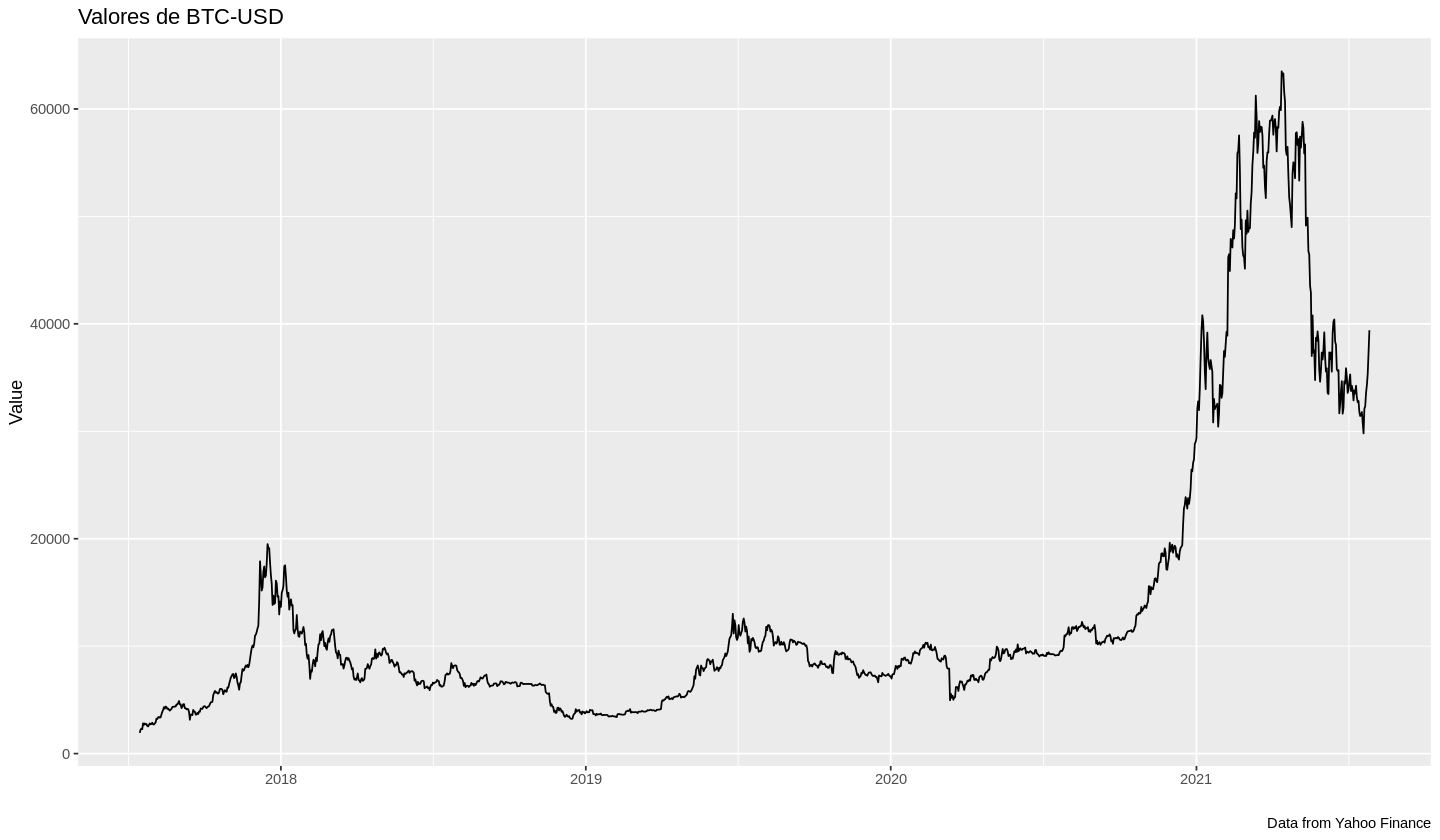

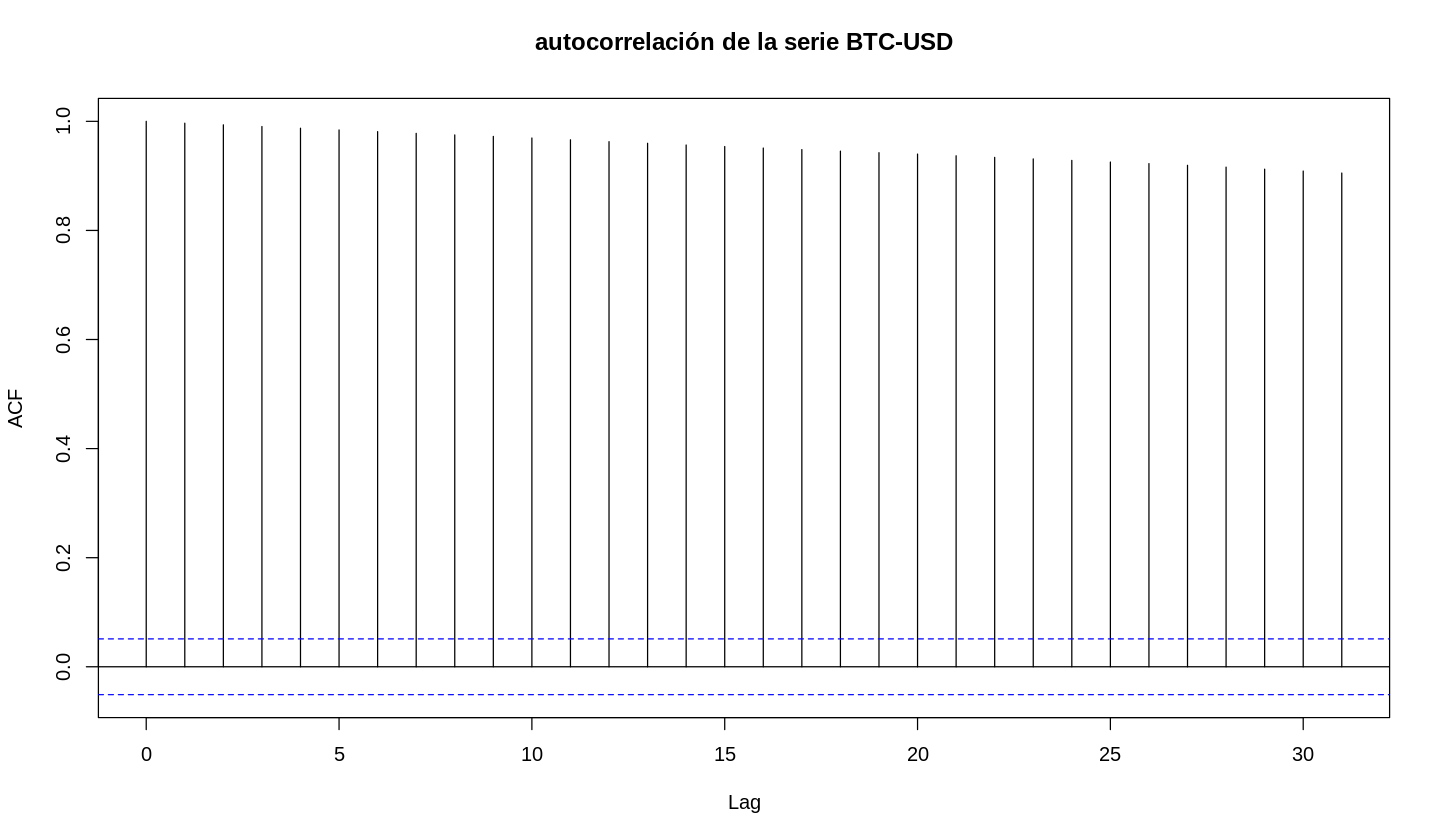

In [4]:
# carga de librerías
library(cowplot)
library(tidyverse)
library(GetBCBData)

# carpeta "figs" para guardar diagramas
if (!dir.exists('figs')) dir.create('figs')

# obtención de los datos
df_prices <- read_rds('data/BTC-GARCH-Data.rds')  #guarda los datos en archivo rds
series_name <- df_prices$series_name[1]

# gráfica con los valores de BTC-USD
p1 = ggplot(df_prices, aes(x = ref.date, y = price.adjusted)) + 
  geom_line() + 
  labs(title = paste0('Valores de ', series_name),
       x = '',
       y = 'Value',
       caption = 'Data from Yahoo Finance') 
p1

#acf de la serie para comprobar que no es estacionaria
acf(df_prices$price.adjusted, main='autocorrelación de la serie BTC-USD')

Se ve claramente que la serie no es estacionaria

## 2. Análisis exploratorio
Transformaciones, búsqueda de tendencias o ciclos. Estacionarizacion.

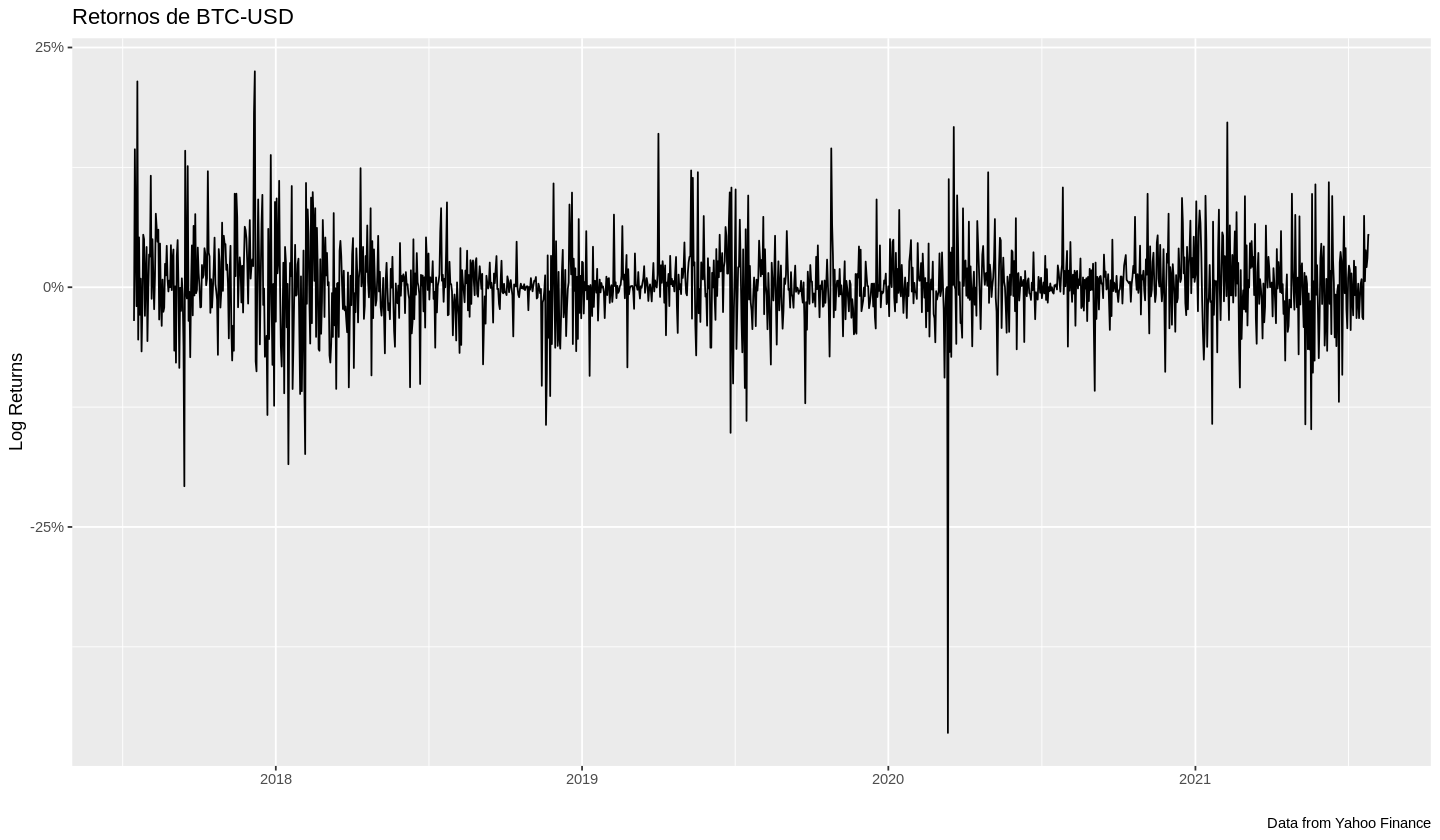

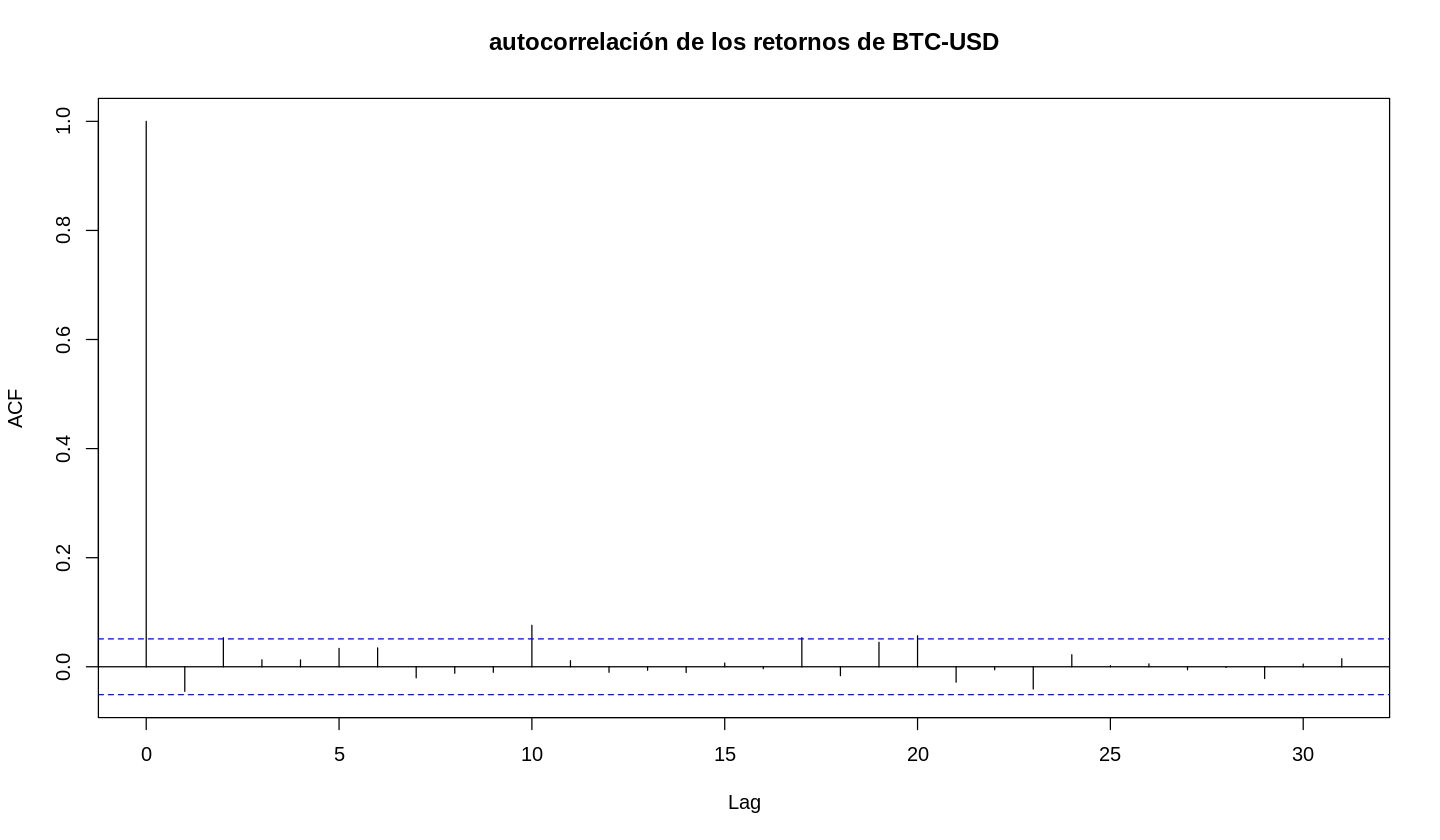

In [13]:
# se transforma la serie llevándola a sus retornos logarítmicos
p2 = ggplot(df_prices, 
             aes(x = ref.date, y = log_ret)) + 
  geom_line() + 
  labs(title = paste0('Retornos de ', series_name),
       x = '',
       y = 'Log Returns',
       caption = 'Data from Yahoo Finance') + 
  scale_y_continuous(labels = scales::percent) + 
  scale_color_brewer(palette = 'BrBG')

p2

#acf de la serie para comprobar que es estacionaria

acf(df_prices$log_ret, main='autocorrelación de los retornos de BTC-USD')

Se usa el retorno logarítmico debido a sus propiedades de estacionalidad y ergodicidad (esto implica que un proceso aletorio no cambiará sus características estadísticas con el tiempo y que además pueden ser deducidas a partir de una muestra suficientemente grande). La mayoría de los retornos están centrados alrededor de cero, y los grandes cambios de valor tienden a ocurrir en un período corto. Esto se denomina volatility clustering. 
Por otro lado se ve qué la volatilidad no es constante (heterocedasticidad).

Se prueba hacer una ajuste por ARMA

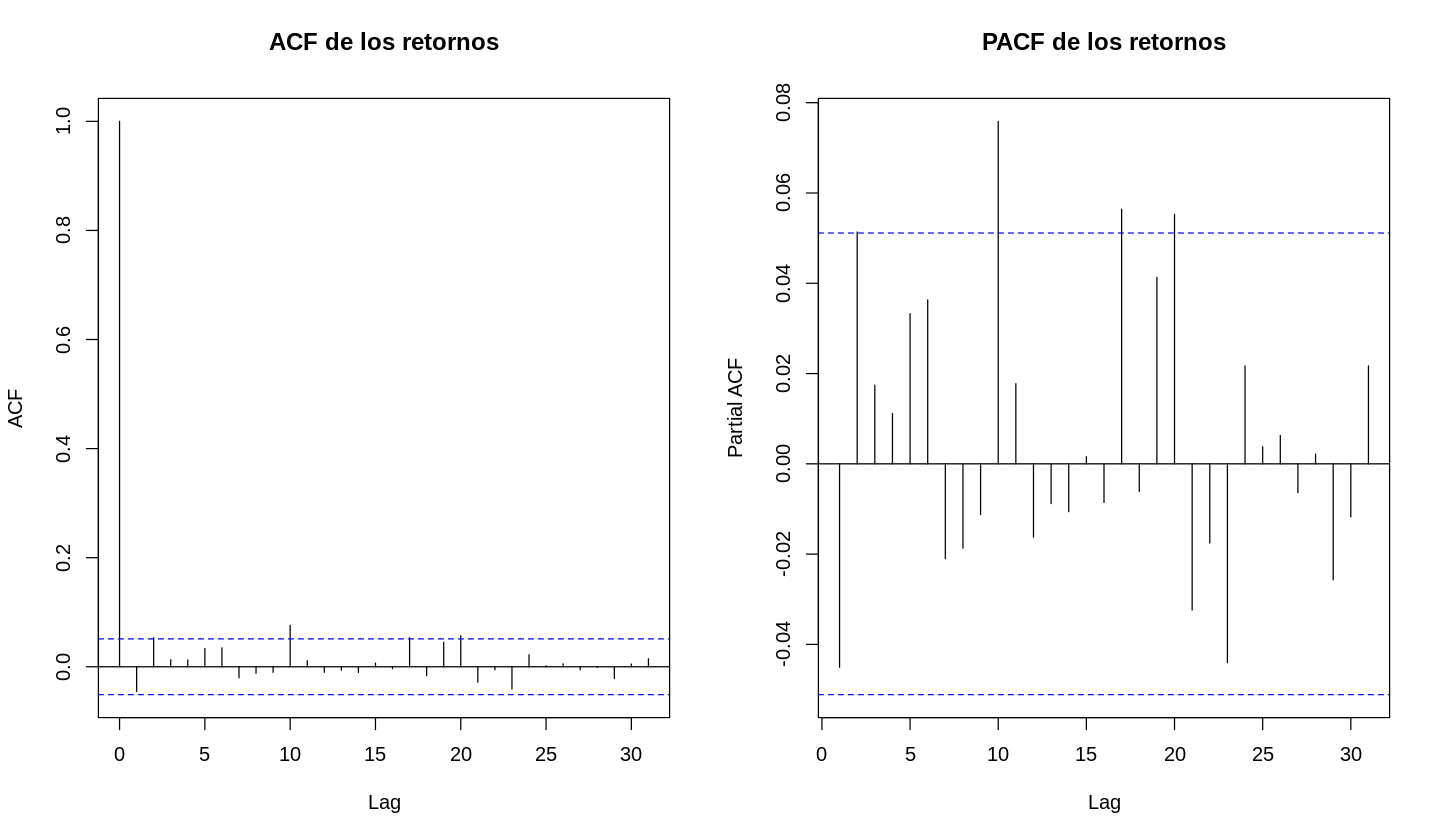

In [14]:
# se hace el acf y el pacf para los órdenes del ARMA
par(mfrow=c(1,2))
acf(df_prices$log_ret, main='ACF de los retornos')
pacf(df_prices$log_ret, main='PACF de los retornos')

In [8]:
# los órdenes del ARMA  no se ven claramentel del análisis ACF y PACF. Se prueba con un AR = 1.
library(forecast)

fit_arma = Arima(df_prices$log_ret, order=c(1,0,0),include.mean = TRUE)
summary(fit_arma)

ajuste_arma = fitted(fit_arma)

Series: df_prices$log_ret 
ARIMA(1,0,0) with non-zero mean 

Coefficients:
          ar1    mean
      -0.0451  0.0020
s.e.   0.0261  0.0011

sigma^2 estimated as 0.00188:  log likelihood=2526.63
AIC=-5047.26   AICc=-5047.25   BIC=-5031.39

Training set error measures:
                        ME       RMSE        MAE      MPE     MAPE      MASE
Training set -6.228755e-06 0.04333017 0.02856285 106.5077 132.0509 0.6590596
                    ACF1
Training set 0.002307734


Los coeficientes de la media y del AR, no son significativos

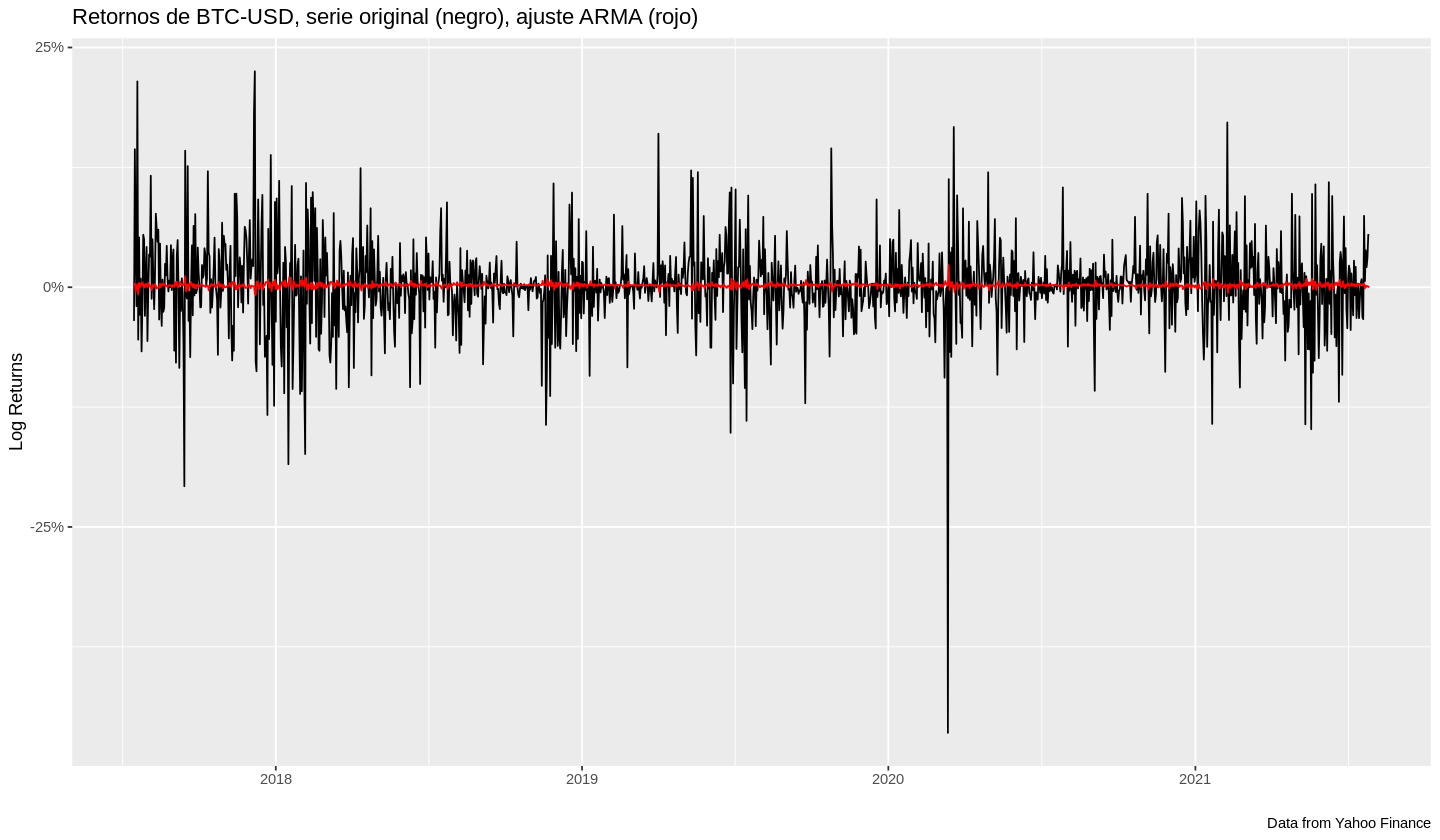

In [7]:
ggplot(df_prices, 
             aes(x = ref.date, y = log_ret)) + 
  geom_line() + 
  labs(title = 'Retornos de BTC-USD, serie original (negro), ajuste ARMA (rojo)',
       x = '',
       y = 'Log Returns',
       caption = 'Data from Yahoo Finance') + 
  geom_line(aes(x = df_prices$ref.date, y = ajuste_arma), color='red')+
  scale_y_continuous(labels = scales::percent) + 
  scale_color_brewer(palette = 'BrBG') 
 


	Ljung-Box test

data:  Residuals from ARIMA(1,0,0) with non-zero mean
Q* = 17.954, df = 8, p-value = 0.02158

Model df: 2.   Total lags used: 10



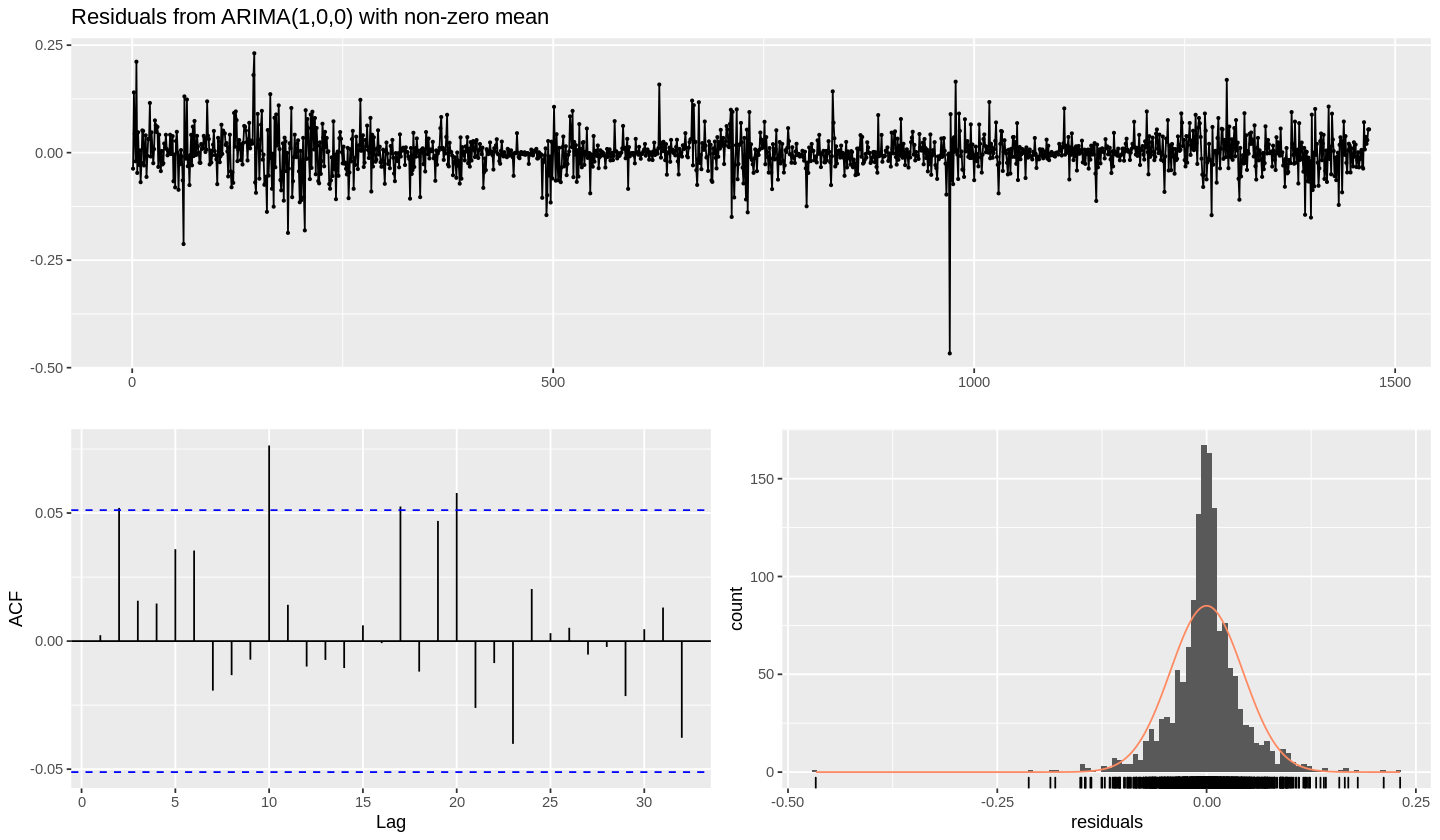

In [9]:
checkresiduals(fit_arma)

Analizando el ajuste por ARMA, si bien logra ajustar la media, los residuos se presentan como ruido blanco de amplitud variable en el tiempo. El no poder detectar esta variabilidad, hace que los modelos regresivos no logren seguir las variaciones de la serie dadas por la volatilidad, presentando intervalos de confianza muy pequeños.
Los modelos ARCH y GARCH atacan el problema de las series con volatilidad o varianza variables en el tiempo.
La volatilidad se define como $\sigma_{t}$, donde $\sigma_{t}^2$ es la varianza de la serie de retornos.
En cuanto a la ACF, en retornos financieros, se espera tener baja autocorrelación, debido que los retornos pasados no pueden explicar retornos futuros.

Los modelos ARCH y GARCH no solo corrigen las deficiencias de la regresión de mínimos como el ARMA, sino que también predicen la varianza.

Un modelo ARCH(m) establece que la varianza condicional es función de los retornos pasados:
\begin{equation}
  \begin{aligned}
     r_{t}         &= \sigma_{t} \epsilon_{t} \\ 
     \sigma_{t}^2    &= \alpha_{0} + \alpha_{1} r_{t-1}^2 + ... +\alpha_{q} r_{t-m}^2 
       \label{eqn:example} 
  \end{aligned}
\end{equation}

Donde $r_{t}$ son los retornos en el tiempo "t" (residuos de un ajuste regresivo de media, modelado como un proceso de ruido blanco), $\sigma_{t}^2$ es la varianza condicional en el tiempo "t", $\alpha_{q}$ son los diferentes parámetros del modelo ARCH a ser estimados, y $\epsilon_{t}$ es una secuencia de variables aleatorias independientes e idénticamente distribuídas con media cero y varianza 1.
Por tanto, el modelo ARCH modela la varianza en un tiempo "t" como función de los residuos del proceso de ajuste de media.


En el modelo GARCH(p,q) se establece que la varianza condicional es función de los retornos pasados y también de las varianzas pasadas:
\begin{equation}
  \begin{aligned}
    r_{t}         &= \sigma_{t} \epsilon_{t} \\ 
    \sigma_{t}^2    &= \alpha_{0} + \sum_{i=1}^q \alpha_{i} r_{t-1}^2 + \sum_{i=1}^p \beta_{i} \sigma_{t-i}^2 
      \label{eqn:example} 
  \end{aligned}
\end{equation}

Una posible crítica a los modelos ARCH/GARCH, es que al ser la varianza condicional una función lineal del cuadrado de las innovaciones pasadas, implica una simetría en el efecto, donde una cambio positivo afecta a la volatilidad de la misma forma que un cambio negativo.
Los modelos EGARCH y GJR-GARCH permiten los efectos asimétricos, siguiendo la idea que la volatilidad puede subir en respuesta a malas noticias y puede bajar frente a una buena noticia.
El EGARCH y GJR-GACRH toman en cuenta el comportamiento asimétrico con el coeficiente $\delta_{i}$.
Un valor significativo de $\delta_{i}$ indica que cuando hay malas noticias en el mercado, los retornos son negativos pero la volatilidad aumenta.

ARCH Test de Engle.
El Test verifica que $r_{t}$ no presenta efectos ARCH.
Por tanto, se verifica por la hipótesis nula (observando los valores de p/value) que la serie es heterocedástica.

In [10]:
library(MTS)
archTest(df_prices$log_ret)

Q(m) of squared series(LM test):  
Test statistic:  38.40773  p-value:  3.222323e-05 
Rank-based Test:  
Test statistic:  433.6058  p-value:  0 


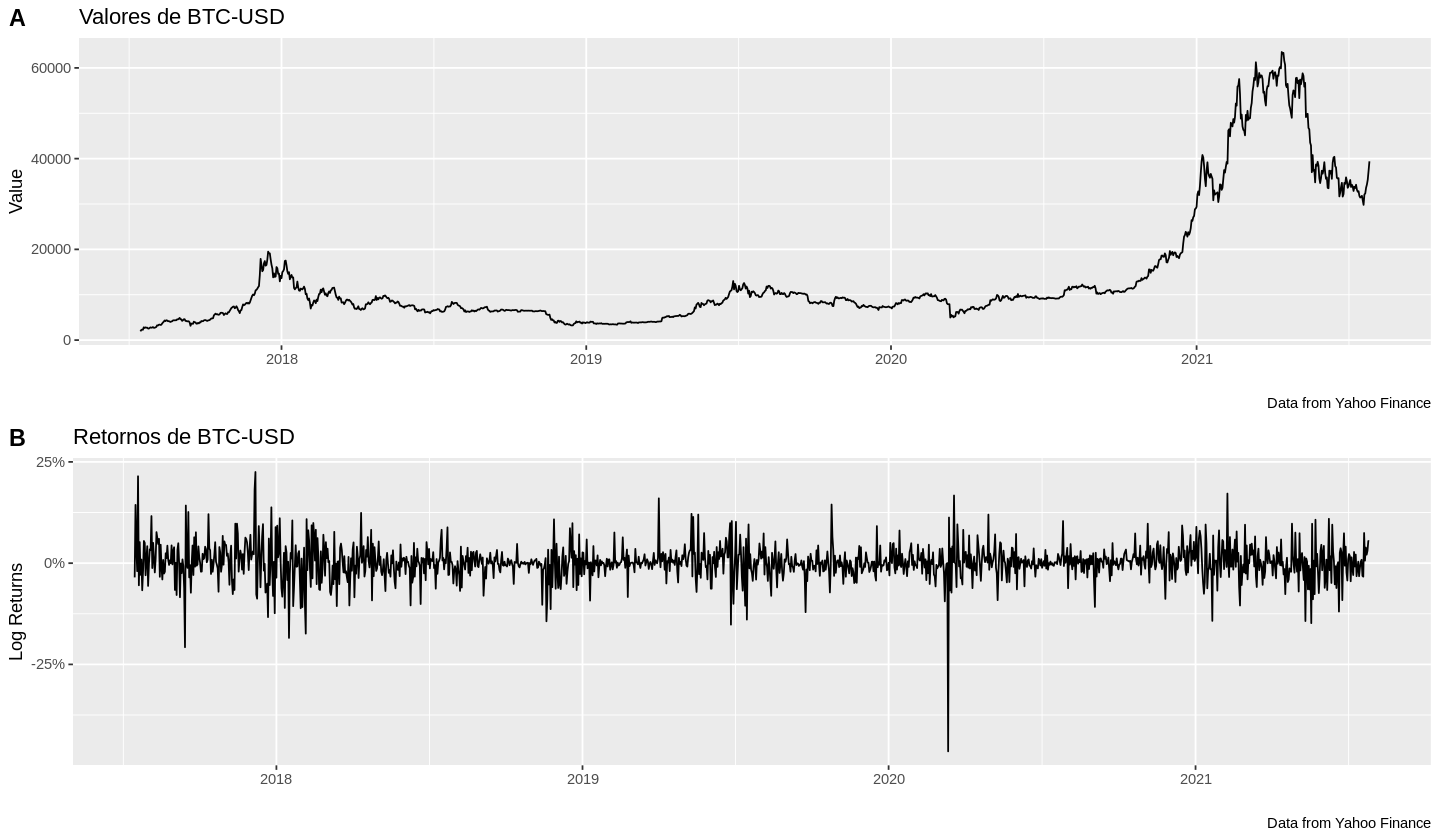

In [11]:
# grafica ambos plots (serie BTC-USD y retornos)

plot_grid(p1, p2, nrow = 2, 
               labels = 'AUTO')

## 3.1 Modelos Estadísticos: GARCH

Paquetes GARCH disponibles: Los paquetes actualmente mantenidos con fGARCH y RUGARCH, se optó por el 2do que tiene más opciones y modelos.

Los modelos GARCH del paquete rugarch, estiman la media por ARMA y la varianza por GARCH. 

Los órdenes para el componente ARMA del modelo, ya se vio que eran cero.

Se hacen los analisis de ACF y PACF de $r_{t}^2$ para ver los coeficientes del ajuste GARCH, dado que el orden del ARMA es 0 y que $r_{t}$ ya es ruido blanco. Es decir, que el $r_{t}$ se puede considerar como el residuo de un proceso regresivo de ajuste de media, y por tanto $r_{t}^2$ puede considerarse como un proxy de $\sigma_{t}^2$

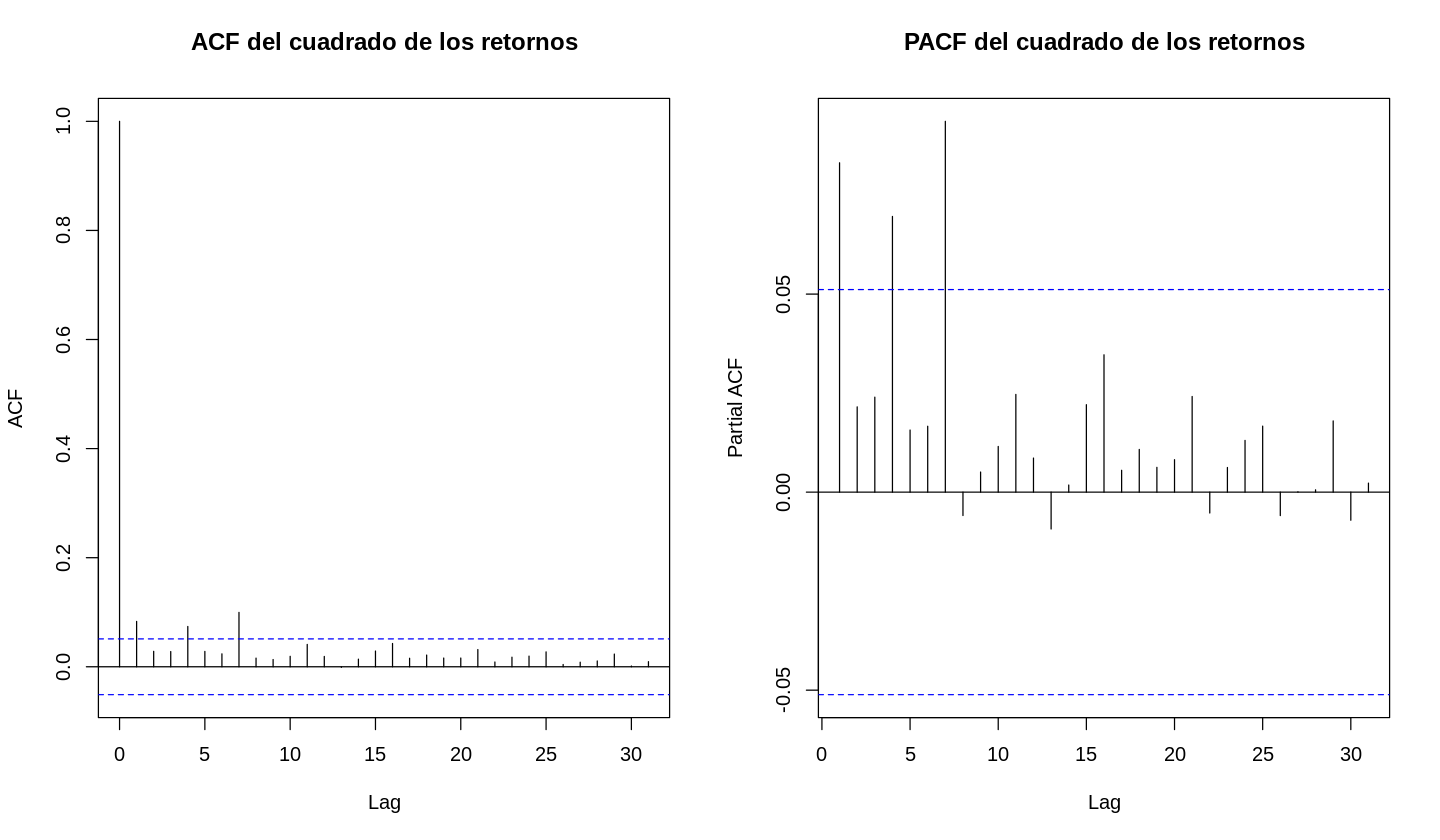

In [15]:
par(mfrow=c(1,2))
acf((df_prices$log_ret)^2, main='ACF del cuadrado de los retornos')  # da el "q"
pacf((df_prices$log_ret)^2, main='PACF del cuadrado de los retornos') # da el "p"

#### Estimación de modelos GARCH

Se realizaron las estimaciones con 3 tipos de modelos GARCH con el dataset de entrenamiento, con igual número de lags y 3 distribuciones diferentes.
Solamente se dejó un coeficiente constante para la media (sin coeficientes ARMA) y lag=1 para cada uno de los modelos de volatilidad (verificado por los ACF y PACF de los cuadrados de los retornos y aplicando el principio de parsimonia). Se guarda el resultado de la comparativa en una tabla en formato html.

In [18]:
# Funciones auxiliares [1]
# Reformats rugarch output to texreg
extract.rugarch <- function(fit, 
                            include.rsquared = TRUE, 
                            include.loglike = TRUE, 
                            include.aic = TRUE, 
                            include.bic = TRUE) {
  
  require(texreg)
  
  # extract coefficient table from fit:
  coefnames <- rownames(as.data.frame(fit@fit$coef))
  coefs <- fit@fit$coef
  se <- as.vector(fit@fit$matcoef[, c(2)])
  pvalues <-  as.vector(fit@fit$matcoef[, c(4)])       # numeric vector with p-values
  
  # create empty GOF vectors and subsequently add GOF statistics from model:
  gof <- numeric()
  gof.names <- character()
  gof.decimal <- logical()
  if (include.rsquared == TRUE) {
    r2 <-  1 - (var(fit@fit$residuals) / var(y))
    gof <- c(gof, r2)
    gof.names <- c(gof.names, "R^2")
    gof.decimal <- c(gof.decimal, TRUE)
  }
  if (include.loglike == TRUE) {
    loglike <- fit@fit$LLH
    gof <- c(gof, loglike)
    gof.names <- c(gof.names, "Log likelihood")
    gof.decimal <- c(gof.decimal, TRUE)
  }
  if (include.aic == TRUE) {
    aic <- infocriteria(fit)[c(1)]
    gof <- c(gof, aic)
    gof.names <- c(gof.names, "AIC")
    gof.decimal <- c(gof.decimal, TRUE)
  }
  
  if (include.bic == TRUE) {
    bic <- infocriteria(fit)[c(2)]
    gof <- c(gof, bic)
    gof.names <- c(gof.names, "BIC")
    gof.decimal <- c(gof.decimal, TRUE)
  }
  
  # include distribution and type variance
# browser()
#   variance_model <- fit@model$modeldesc$vmodel
#   type_dist <- fit@model$modeldesc$distribution
#   gof <- c(gof, variance_model, type_dist)
#   gof.names <- c(gof.names, "Variance Model", 'Distribution')
#   gof.decimal <- c(gof.decimal, TRUE, TRUE)
  
  # create texreg object:
  tr <- createTexreg(
    coef.names = coefnames, 
    coef = coefs,
    se = se,
    pvalues = pvalues, 
    gof.names = gof.names, 
    gof = gof, 
    gof.decimal = gof.decimal
  )
  return(tr)
}


# Se estiman tres modelos simples de GARCH con 3 distribuciones 
# se guarda el resultado de la comparación en un archivo html
# se estima en train para después evaluar la predicción para test

ar_lag <- 0 # lag usado para el término AR de la media 
ma_lag <- 0 # lag usado para el término MA de la media 
arch_lag <- 1 # lag para el efecto ARCH (es el "q")
garch_lag <- 1 # lag para el efecto GARCH (es el "p")
models_to_estimate <- c('sGARCH', 'eGARCH', 'gjrGARCH') 
# model Valid models (currently implemented) are “sGARCH”, “fGARCH”, “eGARCH”, “gjrGARCH”, “apARCH” and “iGARCH” 
# and “csGARCH”. submodel If the model is “fGARCH”, valid submodels are “GARCH”, “TGARCH”, “AVGARCH”, “NGARCH”, 
# “NAGARCH”, “APARCH”,“GJRGARCH” and “ALLGARCH”. 

distribution_to_estimate <- c('norm', 'std', 'ged') # distribucion del ruido.  
# se consideraron 3 funciones de densidad de probabilidad de los errores: Student t-distribution, normal y la
# generalised error distribution (GED). Ref[3]
# otra a probar: "nig". Ref[2]

my_html_file <- 'tabs/tab04-estimation_garch.html' # where to save html file?

library(tidyverse)
library(FinTS)
library(texreg)
library(rugarch)


# obtiene todas las combinaciones de los modelos
df_grid <- expand_grid(ar_lag,
                       ma_lag,
                       arch_lag,
                       garch_lag,
                       models_to_estimate,
                       distribution_to_estimate)

# obtención de los datos
df_prices <- read_rds('data/BTC-GARCH-Data.rds')  
# creación de datos de train
df_train <- df_prices %>% 
  filter(ref.date <= train_date)

estimate_garch <- function(ar_lag,
                           ma_lag,
                           arch_lag,
                           garch_lag,
                           models_to_estimate,
                           distribution_to_estimate) {
  
  # estimación de modelos
  my_spec <- ugarchspec(variance.model = list(model = models_to_estimate,
                                              garchOrder = c(arch_lag, 
                                                             garch_lag)),
                        mean.model = list(armaOrder = c(ar_lag,
                                                        ma_lag)), 
                        distribution.model = distribution_to_estimate)
  
  my_garch <- ugarchfit(spec = my_spec, data = df_train$log_ret)
  
  return(my_garch)
}

# estimación de todos los modelos
l_args <- as.list(df_grid)
# pmap() iterate over multiple arguments simultaneously. Allows you to provide any number of arguments in a list. 
l_models <- pmap(.l = l_args, .f = estimate_garch)

# se crea el directorio tabs en caso de que no exista
if (!dir.exists('tabs')) dir.create('tabs')

# reformatea los modelos para el texreg
# map() transform their input by applying a function to each element and returning a vector the same length as the input.
l_models <- map(l_models, extract.rugarch, include.rsquared = FALSE) 

# write custom row
custom_row <- list('Variance Model' = df_grid$models_to_estimate,
                   'Distribution' = df_grid$distribution_to_estimate)
custom_names <- paste0('Model ', 1:length(l_models))

# save to html
htmlreg(l_models, 
        file = my_html_file, 
        custom.gof.rows = custom_row,
        custom.model.names = custom_names, 
        digits = 3)


The table was written to the file 'tabs/tab04-estimation_garch.html'.




#### Elección del mejor modelo ARMA(ar,ma)-GARCH(p,q) para el dataset


Attaching package: ‘lubridate’


The following object is masked from ‘package:cowplot’:

    stamp


The following objects are masked from ‘package:base’:

    date, intersect, setdiff, union





please wait...calculating quantiles...


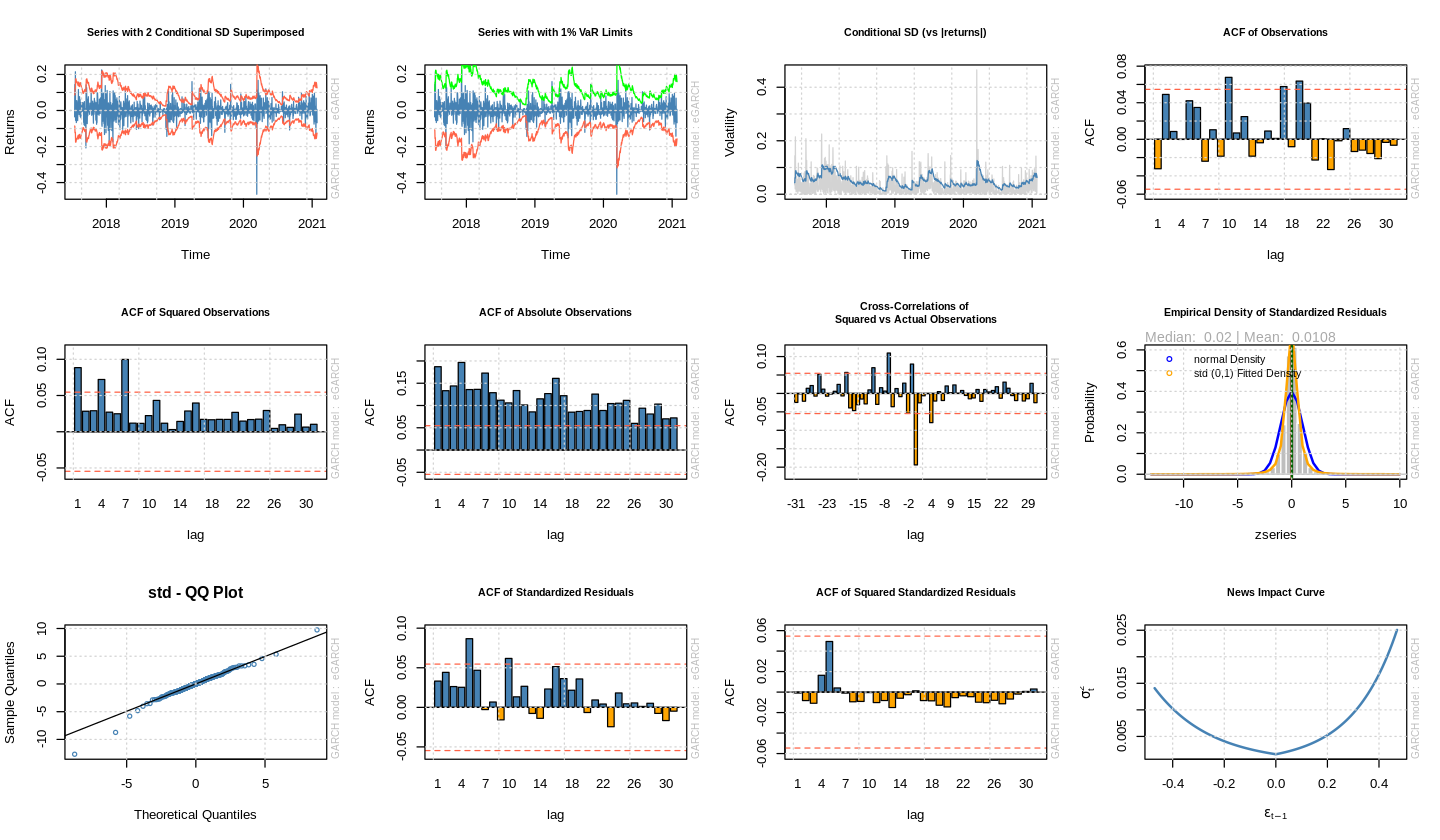


please wait...calculating quantiles...


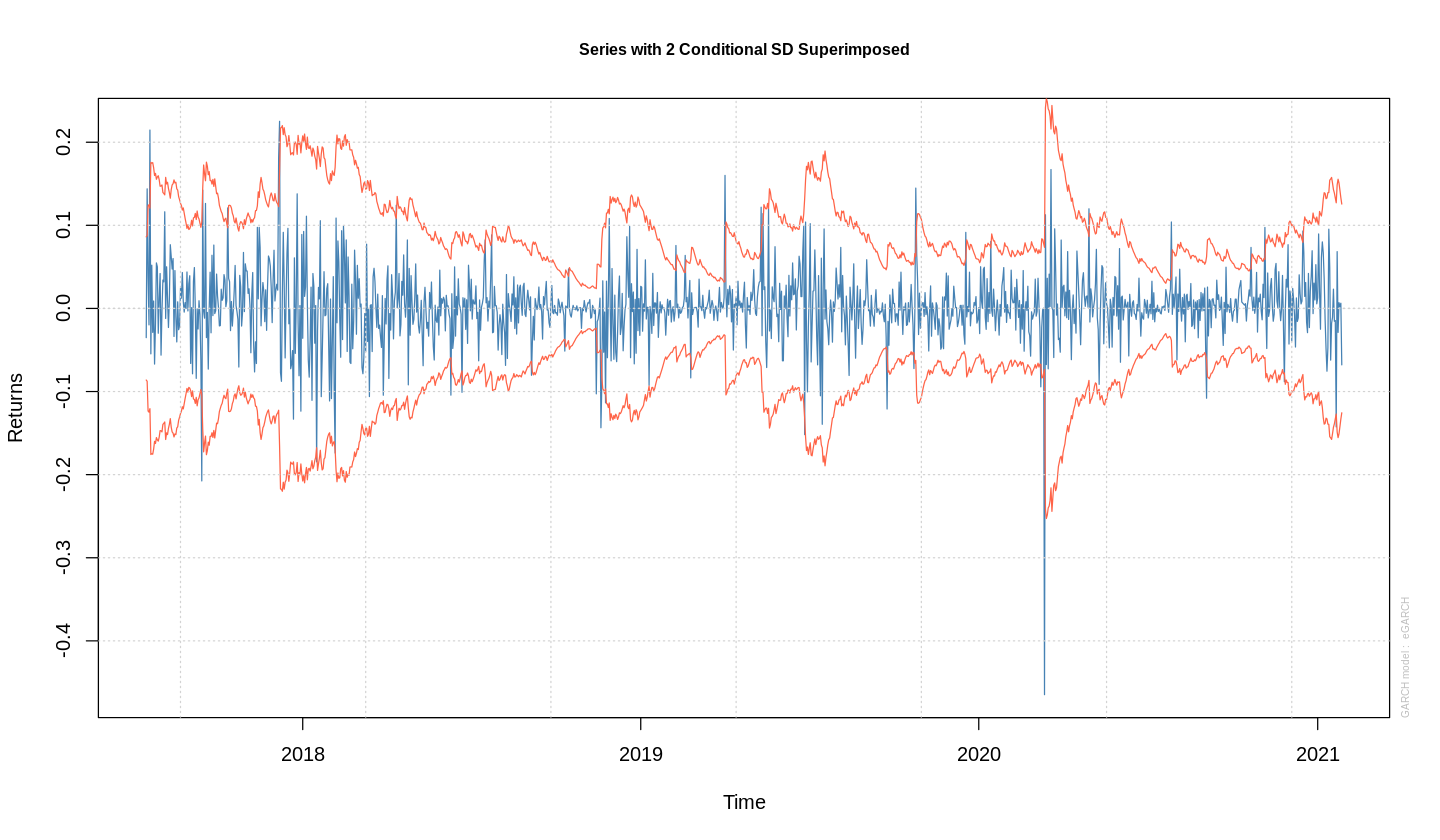

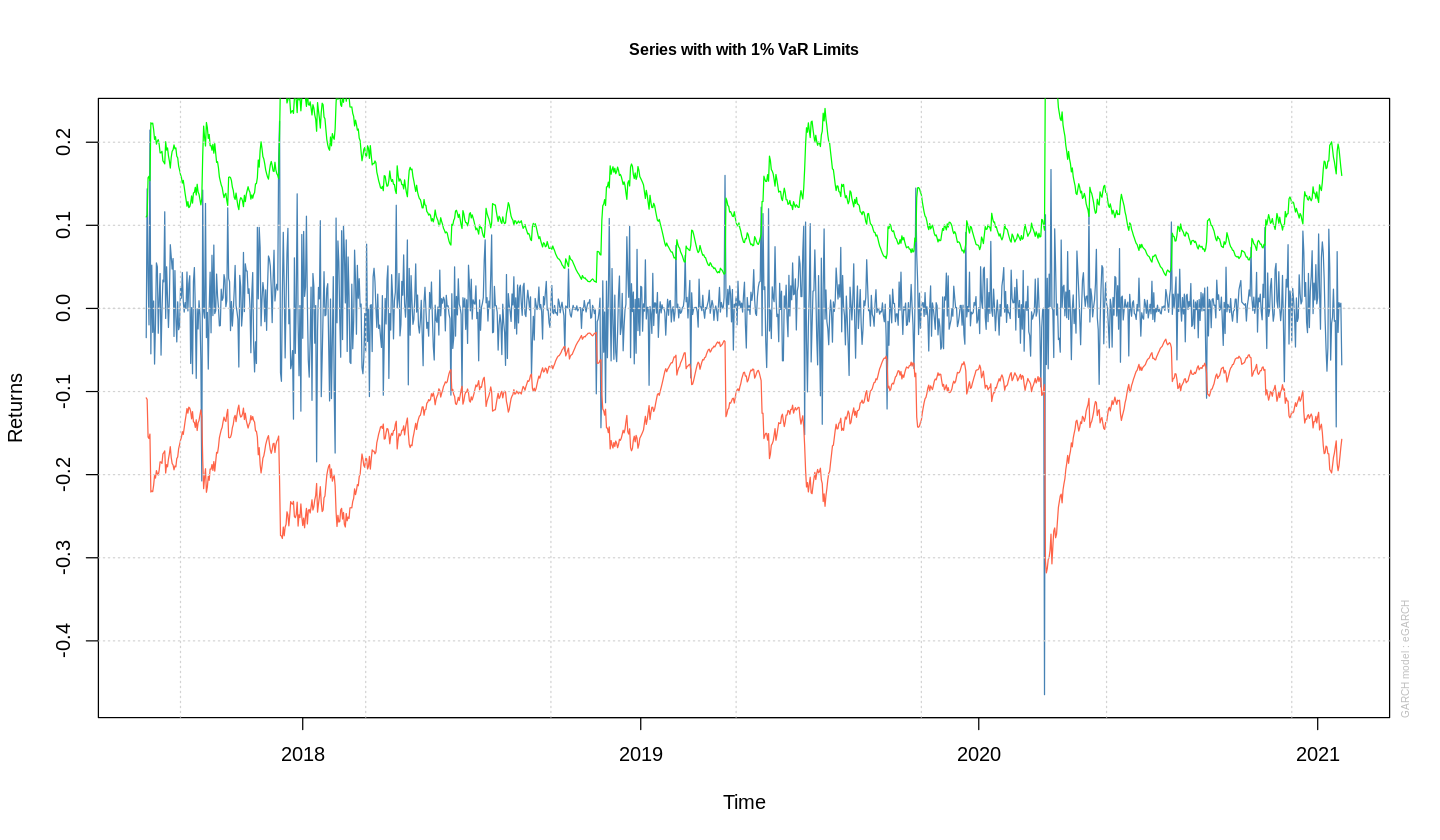

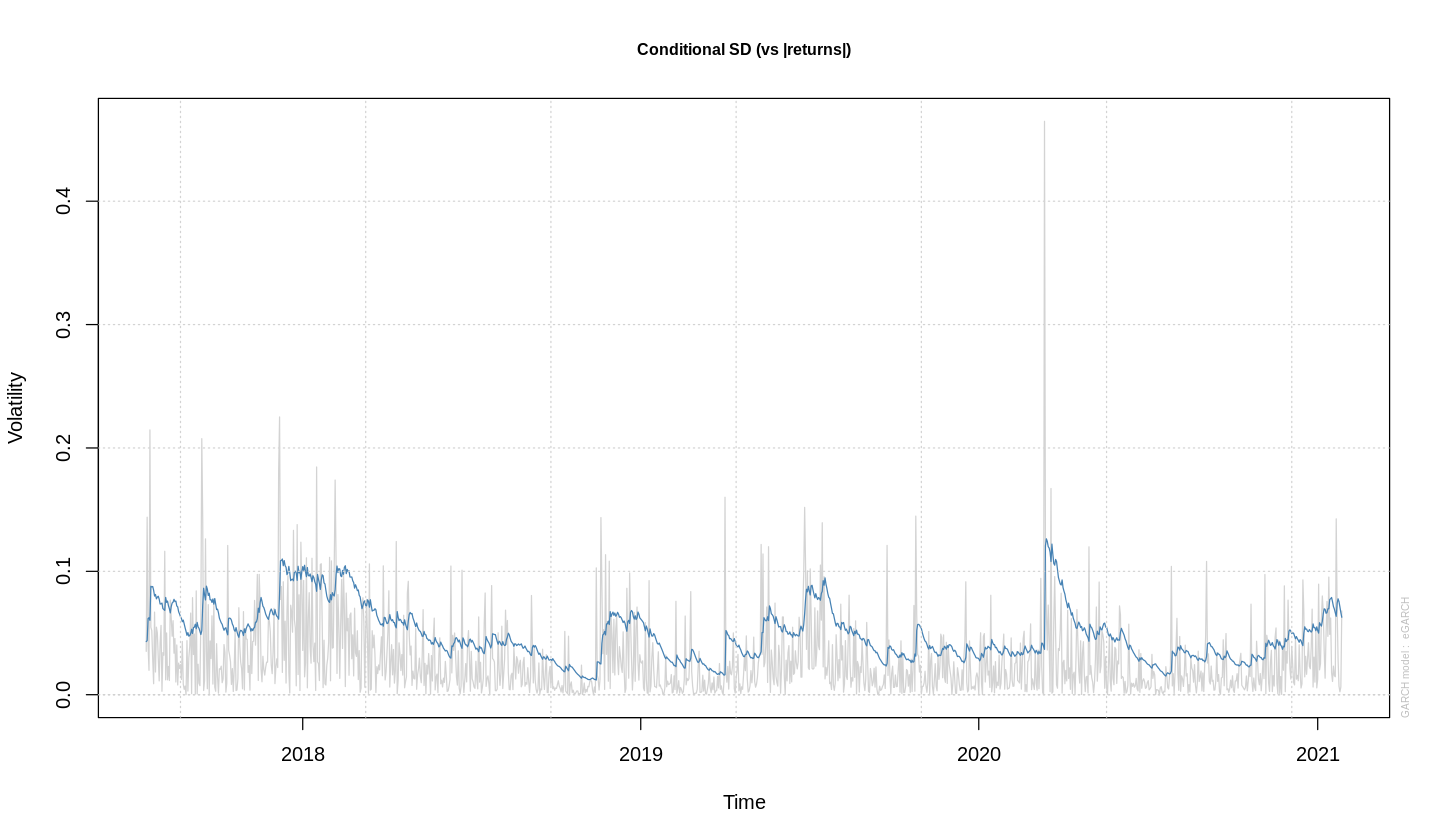

In [19]:
# el mejor modelo fue el eGARCH con distribución student-t
# se calcula el mejor modelo estimado hasta train_date

library(lubridate)

best_spec = ugarchspec(variance.model = list(model = "eGARCH", 
                                             garchOrder = c(arch_lag, garch_lag)),
                       mean.model = list(armaOrder = c(ar_lag, ma_lag)),
                       distribution = "std")


best_model <- ugarchfit(spec = best_spec, 
                           data = df_train$log_ret) 

write_rds(best_model, 'data/garch_model.rds')

best_model@model$modeldata$index = df_train$ref.date  # se igualan los ejes de tiempo para las gráficas

#opciones de ploteo
#1: Series with 2 Conditional SD Superimposed 
#2: Series with 1% VaR Limits 
#3: Conditional SD (vs |returns|) 
#4: ACF of Observations 
#5: ACF of Squared Observations 
#6: ACF of Absolute Observations 
#7: Cross Correlation 
#8: Empirical Density of Standardized Residuals 
#9: QQ-Plot of Standardized Residuals 10: ACF of Standardized Residuals 
#11: ACF of Squared Standardized Residuals 12: News-Impact Curve
plot(best_model,which='all')
plot(best_model,which=1)
plot(best_model,which=2)
plot(best_model,which=3) 
#plot(best_model,which=9)
#plot(best_model,which=8)
# gráfica 3: la línea gris es el plot de la serie. La línea azul representa la volatilidad de la serie.
# Mirando esta gráfica se puede ver cuándo la volatilidad fue alta.

In [20]:
print(best_model)


*---------------------------------*
*          GARCH Model Fit        *
*---------------------------------*

Conditional Variance Dynamics 	
-----------------------------------
GARCH Model	: eGARCH(1,1)
Mean Model	: ARFIMA(0,0,0)
Distribution	: std 

Optimal Parameters
------------------------------------
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.001251    0.000428   2.9202 0.003498
omega  -0.025807    0.013749  -1.8770 0.060514
alpha1  0.026533    0.017737   1.4959 0.134680
beta1   0.995891    0.002610 381.6102 0.000000
gamma1  0.224458    0.020219  11.1013 0.000000
shape   2.694444    0.215616  12.4965 0.000000

Robust Standard Errors:
        Estimate  Std. Error  t value Pr(>|t|)
mu      0.001251    0.000306   4.0854 0.000044
omega  -0.025807    0.020077  -1.2854 0.198646
alpha1  0.026533    0.018329   1.4476 0.147726
beta1   0.995891    0.003019 329.8896 0.000000
gamma1  0.224458    0.021283  10.5461 0.000000
shape   2.694444    0.211937  12.7134 0.000000

LogLikel

##### Intepretación de los resultados
* Verificar que todos los parámetros del GARCH son significativos.
* Information Criteria: El modelo con el menor valor (AIC y BIC) es el mejor.
* Ljung Box Tests se usan para testear la autocorrealación entre los residuos (test de autocorrelación para los errores estandarizados) y para el cuadrado de los residuos (test de autocorrealción para la heterocedasticidad condicional). 
* ARCH LM test: se usa para ver la presencia de efecto ARCH (Null: Adequately fitted ARCH process)

$\alpha$ y $\beta$ deben ser positivos y la suma debe ser menor que 1. Si la suma es cercana a uno, es señal de una persistencia de alta volatilidad.
Los parámetros asimétricos $\gamma$ son significativos, lo que sugiere que la volatilidad del Bitcoin es alta frente a movimientos negativos del retorno.


### Proyecciones y/o validación

#### Análisis de Root Mean Squared Error (RMSE) de la varianza

In [21]:
# CÁLCULO DEL RMS DE PREDICCIÓN
# En train (in sample)
# En test (out sample)

set.seed(20200315) 

# obtención de los datos
df_prices <- read_rds('data/BTC-GARCH-Data.rds')  
# creación de datos de test
df_test <- df_prices %>% 
  filter(ref.date > train_date)
# obtención del modelo
my_model <- read_rds('data/garch_model.rds')  

# IN SAMPLE

daily_variance_train = (sigma(my_model))^2  # la varianza estimada es el cuadrado de sigma de la estimación
variance_proxy_train = (df_train$log_ret)^2  # se toma como proxy de la varianza real, los cuadrados de los retornos
mse_in  = mean((variance_proxy_train - daily_variance_train) ^ 2)
rmse_in = sqrt(mse_in)
mape_in = mean(abs(variance_proxy_train - daily_variance_train) / sqrt(variance_proxy_train))

#print(paste0('Mean Squared Error (in sample) = ', mse_in))
print(paste0('Root Mean Squared Error (in sample) = ', rmse_in))
#print(paste0('Mean Absoute Percentage Error (in sample) = ', mape_in))

# OUT SAMPLE

lag_test = days(last_date - train_date)
n_test = lag_test @ day

forecast_rugarch_sim = ugarchsim(my_model, n.sim = (n_test), m.sim = 1) # modelo simulado con test

daily_variance_test = (sigma(forecast_rugarch_sim))^2  # la varianza simulada es el cuadrado de sigma de la simulación
variance_proxy_test = (df_test$log_ret)^2  # se toma como proxy de la varianza real, los cuadrados de los retornos
mse_out  = mean((variance_proxy_test - daily_variance_test) ^ 2)
rmse_out = sqrt(mse_out)
mape_out = mean(abs(variance_proxy_test - daily_variance_test) / sqrt(variance_proxy_test))

#print(paste0('Mean Squared Error (out sample) = ', mse_out))
print(paste0('Root Mean Squared Error (out sample) = ', rmse_out))
#print(paste0('Mean Absoute Percentage Error (out sample) = ', mape_out))


[1] "Root Mean Squared Error (in sample) = 0.00745282365522153"
[1] "Root Mean Squared Error (out sample) = 0.00424488890084879"


Comparativo con resultados en [3]. Se ve que el RMSE obtenido tanto para in sample, como en out sample, es muy bajo. Lo que indica que el modelo ajusta bien.
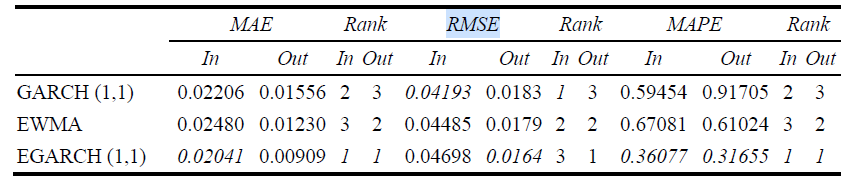

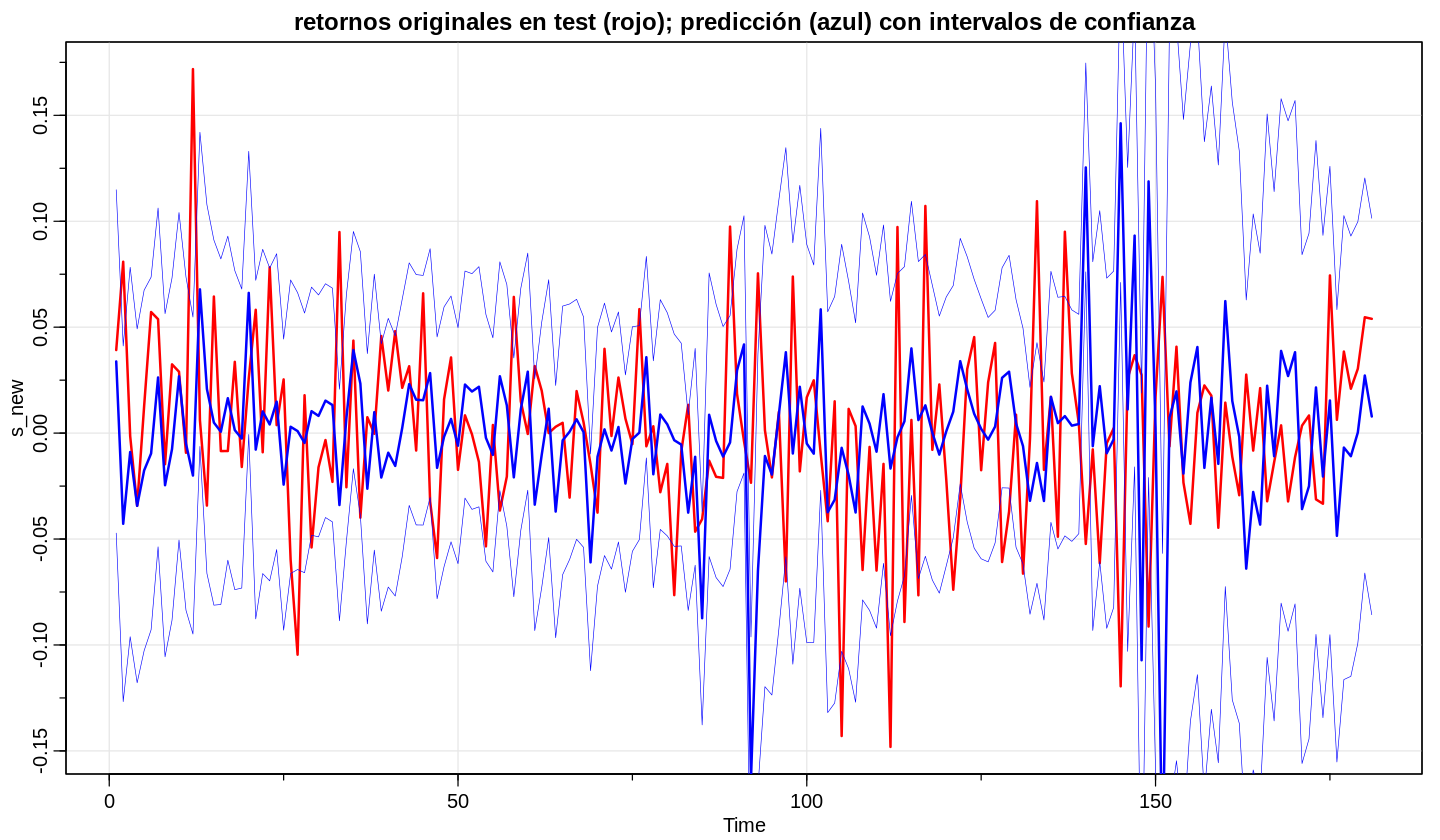

In [23]:
# Forecast con bandas de SD
library(astsa)
n = length(df_test$log_ret)
r_hat = fitted(forecast_rugarch_sim)
sig = sigma(forecast_rugarch_sim)
se = sig/(sqrt(n))

s_new = df_test$log_ret
tsplot(s_new, col=2, lwd=2,  
       main = "retornos originales en test (rojo); predicción (azul) con intervalos de confianza")
lines(r_hat,col=4, lwd=2)
lines(r_hat+2*sig,col=4, lwd=0.5)
lines(r_hat-2*sig,col=4, lwd=0.5)

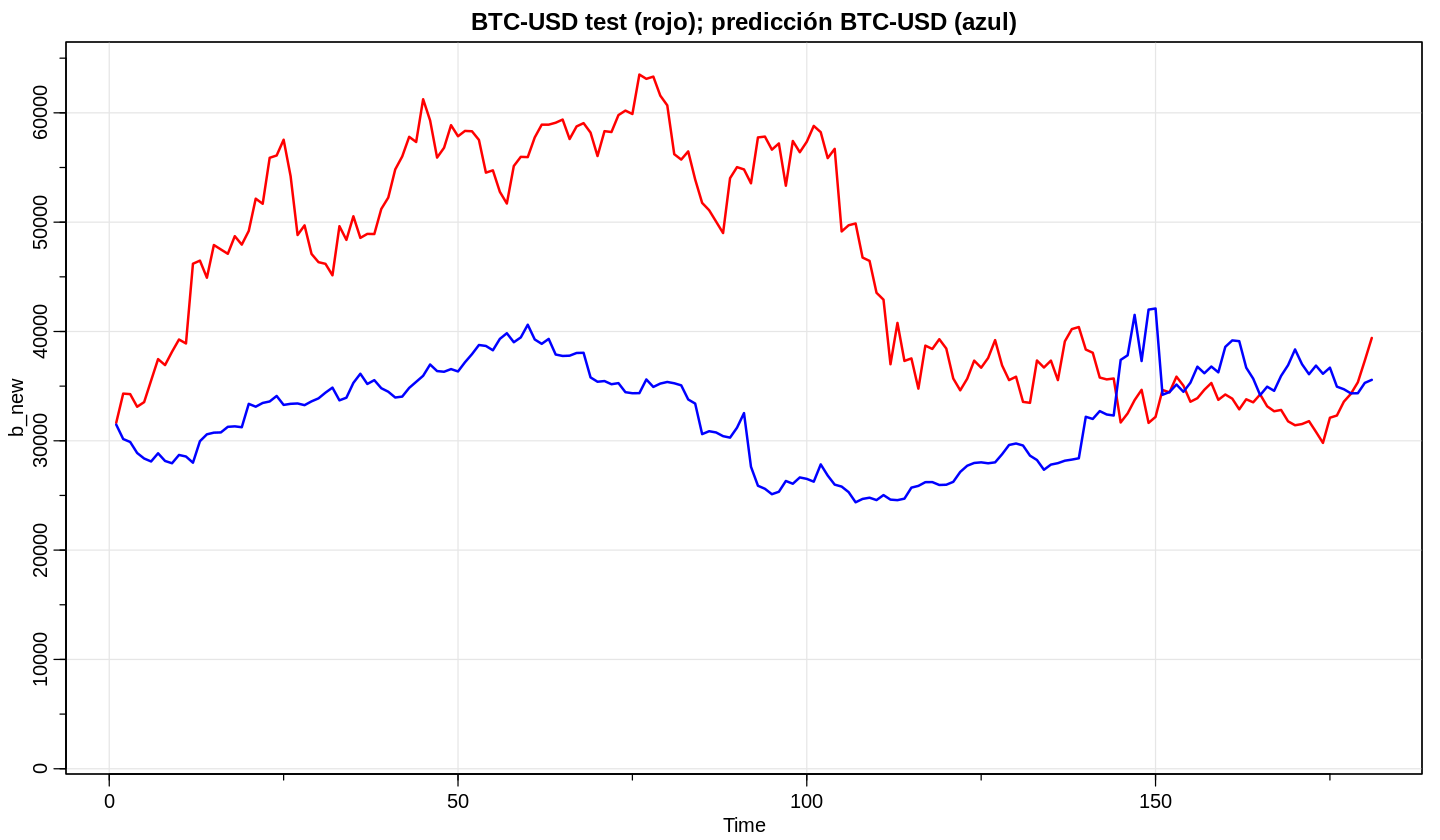

In [25]:
# forecast de la serie BT_USD

n = length(df_test$log_ret)
b_new = df_test$price.adjusted
b_hat = last(df_train$price.adjusted)*cumprod(exp(r_hat))  

#otra forma de hallar el b_hat:
#b_hat[1] = last(df_train$price.adjusted)*exp(r_hat)[1]

#for (i in 2:n) {
#  b_hat[i] = exp(r_hat)[i]*b_hat[i-1]
#}

tsplot(b_new, col=2, lwd=2,  
      main = "BTC-USD test (rojo); predicción BTC-USD (azul)", ylim=c(2000,64000))
lines(b_hat,col=4, lwd=2)
#lines(b_hat2,col=5, lwd=2)

Si bien los intervalos de confianza para las predicciones a futuro ajustan bien, la serie simulada no logra acompañar las variaciones.

#### Simulación y predicción a futuro
Se realizan varias simulaciones en 2 años a futuro y se analizan las probabilidades de que el BTC alcance su máximo histórico [1]

Rows: 548,000
Columns: 6
$ i_sim        <int> 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,…
$ i_t          <int> 0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16…
$ ref_date     <date> 2021-07-27, 2021-07-28, 2021-07-29, 2021-07-30, 2021-07…
$ sim_log_ret  <dbl> 0.0000000000, 0.0338287804, -0.0427986038, -0.0089237285…
$ sim_arit_ret <dbl> 0.0000000000, 0.0344074808, -0.0418956708, -0.0088840302…
$ sim_price    <dbl> 39406.94, 40762.83, 39055.05, 38708.08, 37402.35, 36749.…


`summarise()` ungrouping output (override with `.groups` argument)

Warning message:
“Removed 273314 row(s) containing missing values (geom_path).”
Warning message:
“Removed 2 rows containing missing values (geom_point).”
Warning message:
“Removed 2 rows containing missing values (geom_text).”


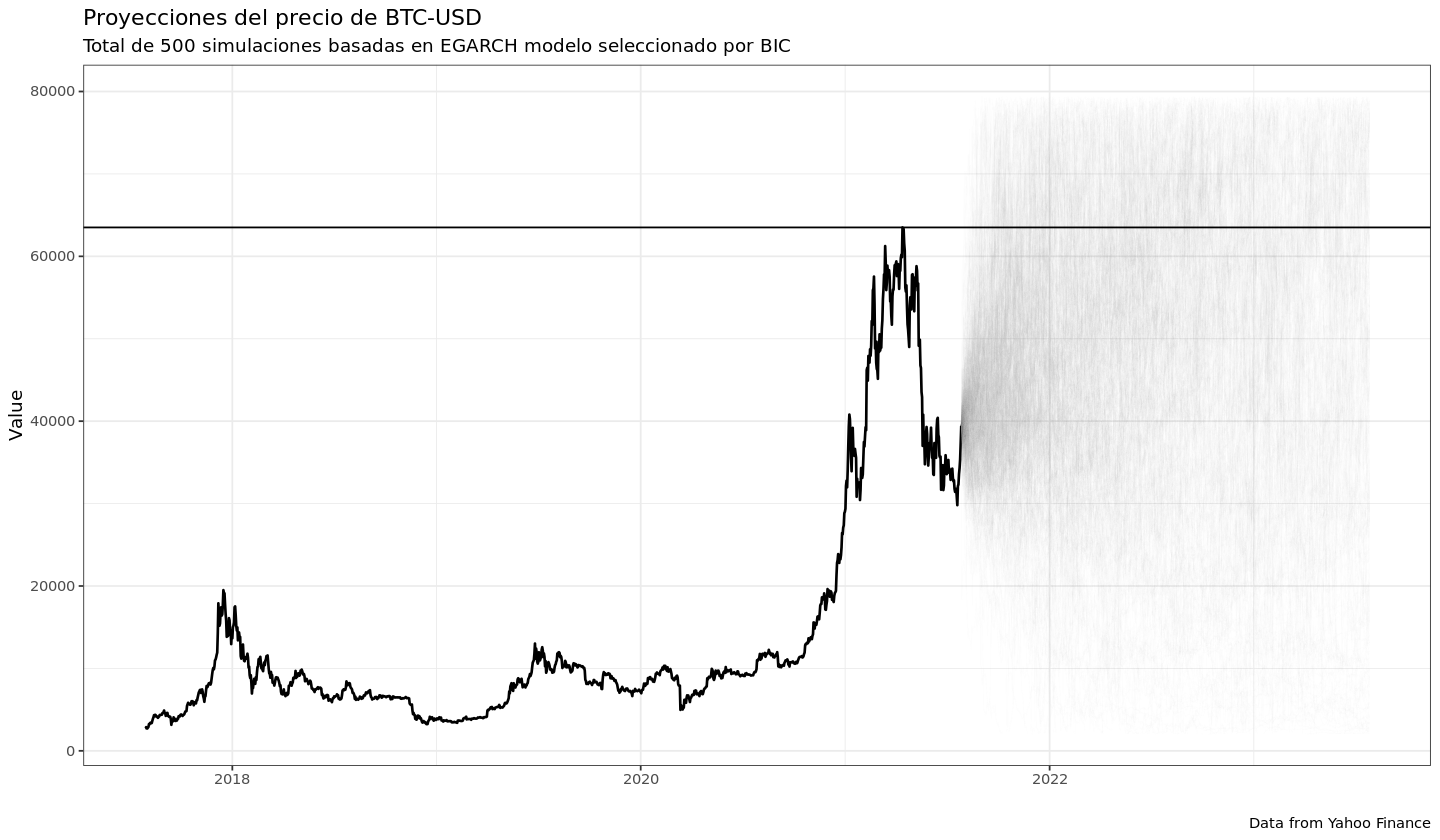

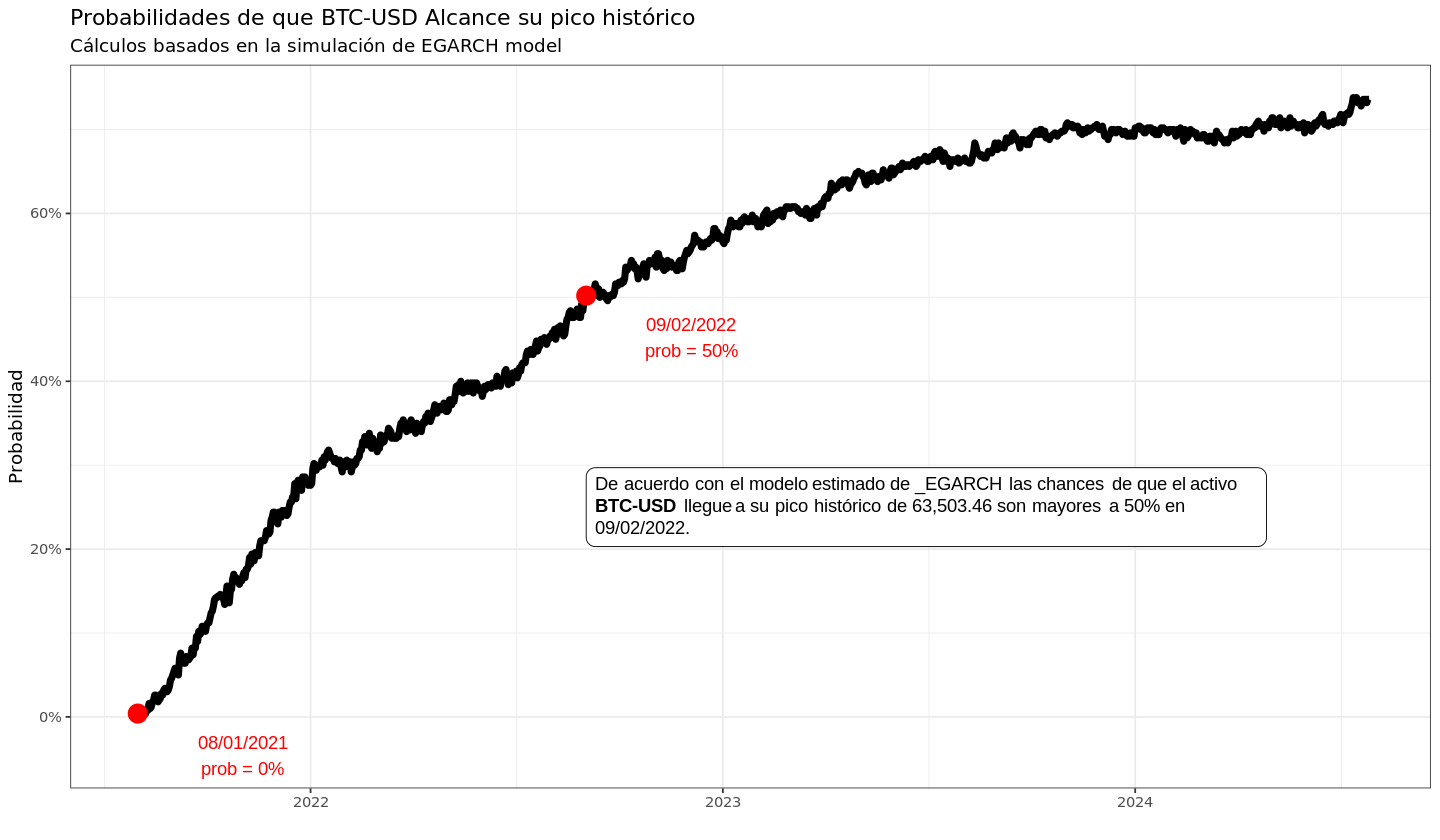

In [26]:
set.seed(20200315) # fix seed for simulations (20200315 replicates the paper's results)
n_sim <- 500 # number of simulations 
n_days_ahead <- 3*365 # Number of days ahead to simulate 

## END OPTIONS

library(tidyverse)
library(ggtext)

#función auxiliar para hacer las simulaciones

do_sim <- function(n_sim = 1000, n_t = 1000, my_garch, df_prices) {
  require(tidyverse)
  require(rugarch)
  
  do_single_sim <- function(i_sim, n_t, my_garch, df_prices) {
    rugarch_sim = ugarchsim(my_garch, n.sim = n_t, 
                            m.sim = 1)
    
    sim_series <- rugarch_sim@simulation$seriesSim
    
    df_sim_out <- tibble(i_sim = i_sim, 
                         i_t = 0:length(sim_series),
                         ref_date = last(df_prices$ref.date) + i_t,
                         sim_log_ret = c(0, sim_series), # model was estimated on log returns
                         sim_arit_ret = exp(sim_log_ret)-1, # use arit return for price calc
                         sim_price = last(df_prices$price.adjusted)*(cumprod(1+sim_arit_ret)) )
    return(df_sim_out) 
  }
  
  df_out <- bind_rows(map(.x = 1:n_sim, 
                          .f = do_single_sim, 
                          my_garch = my_garch, 
                          n_t = n_t,
                          df_prices=df_prices))
  
  
}

# get price and model data
df_prices <- read_rds('data/BTC-GARCH-Data.rds')
my_garch <- read_rds('data/garch_model.rds')
#my_garch = ugarchfit(spec = best_spec, 
 #                        data = df_prices$log_ret)  # da peor
series_name <- df_prices$series_name[1]


# do simulations

df_sim <- do_sim(n_sim = n_sim, 
                 n_t = n_days_ahead, 
                 my_garch, 
                 df_prices = df_prices)

glimpse(df_sim )

# calculate probabilities of reaching peak value
tab_prob <- df_sim %>%
  group_by(ref_date) %>%
  summarise(prob = mean(sim_price > max(df_prices$price.adjusted)))

n_years_back <- 4
df_prices_temp <- df_prices %>%
  dplyr::filter(ref.date > max(ref.date) - n_years_back*365)

my_garch_name <- toupper(as.character(my_garch@model$modeldesc$vmodel))

ggplot() + 
  geom_line(data = df_prices_temp, 
            aes(x = ref.date, y = price.adjusted), color = 'black', size = 0.75)  + 
  geom_line(data = df_sim, 
            aes(x = ref_date, 
                y = sim_price, 
                group = i_sim),
            color = 'grey', 
            size = 0.25,
            alpha = 0.015) + 
  theme_bw(base_family = "TT Times New Roman") + 
  geom_hline(yintercept = max(df_prices_temp$price.adjusted)) + 
  labs(title = paste0('Proyecciones del precio de ', series_name),
       subtitle = paste0('Total de ', n_sim, ' simulaciones basadas en ',
                         my_garch_name, 
                         ' modelo seleccionado por BIC'),
       caption = 'Data from Yahoo Finance',
       x = '',
       y = 'Value') + 
  ylim(c(0.75*min(df_prices_temp$price.adjusted), 
         1.25*max(df_prices_temp$price.adjusted))) + 
  xlim(c(max(df_prices_temp$ref.date) - n_years_back*365,
         max(df_prices_temp$ref.date) + 2*365) )


# probabilidad de que llegue el punto máximo
my_idx_date <- first(which(tab_prob$prob > 0.5))
df_date <- tibble(idx = c(first(which(tab_prob$prob > 0.001)),
                          first(which(tab_prob$prob > 0.5)),
                          first(which(tab_prob$prob > 0.75)),
                          first(which(tab_prob$prob > 0.95))),
                  ref_date = tab_prob$ref_date[idx],
                  prob = tab_prob$prob[idx],
                  my_text = paste0(format(ref_date, '%m/%d/%Y'),
                                   '\nprob = ', scales::percent(prob) ) )

df_textbox <- tibble(ref_date = df_date$ref_date[2],
                     prob = 0.25,
                     label = paste0('De acuerdo con el modelo estimado de _', my_garch_name,  
                                    ' las chances de que el activo **', series_name, '** llegue ',
                                    'a su pico histórico de ', 
                                    format(max(df_prices$price.adjusted), 
                                           big.mark = ',',
                                           decimal.mark = '.'),
                                    ' son mayores a 50% en ', format(ref_date, '%m/%d/%Y'), '.') )

ggplot(tab_prob, aes(x = ref_date, y = prob) ) + 
  geom_line(size = 2) + 
  labs(title = paste0('Probabilidades de que ', series_name, ' Alcance su pico histórico'),
       subtitle = paste0('Cálculos basados en la simulación de ',
                         my_garch_name, 
                         ' model'),
       x = '',
       y = 'Probabilidad') + 
  scale_y_continuous(labels = scales::percent) + 
  geom_point(data = df_date,
             aes(x = ref_date, y = prob), size = 5, color = 'red') + 
  geom_text(data = df_date, aes(x = ref_date, y = prob, 
                                label = my_text), 
            nudge_x = nrow(tab_prob)*0.085,
            nudge_y = -0.05,
            color ='red', check_overlap = TRUE) + 
  geom_textbox(data = df_textbox, 
               mapping = aes(x = ref_date, 
                             y = prob, 
                             label = label),
               width = unit(0.5, "npc"),
               #fill = "cornsilk",
               hjust = 0) + 
  theme_bw(base_family = "TT Times New Roman")

##### Forecast
Ahora se realiza la predicción en test utilizando la función forecast de rugarch (ugarchforecast).
El forecast está basado en el valor esperado de las innovaciones y por tanto de la distribución elegida.
La predicción de un paso está basada en el valor de los datos previos, mientras que la predicción "n-step ahead" está basada en la esperanza no condicional de los modelos.

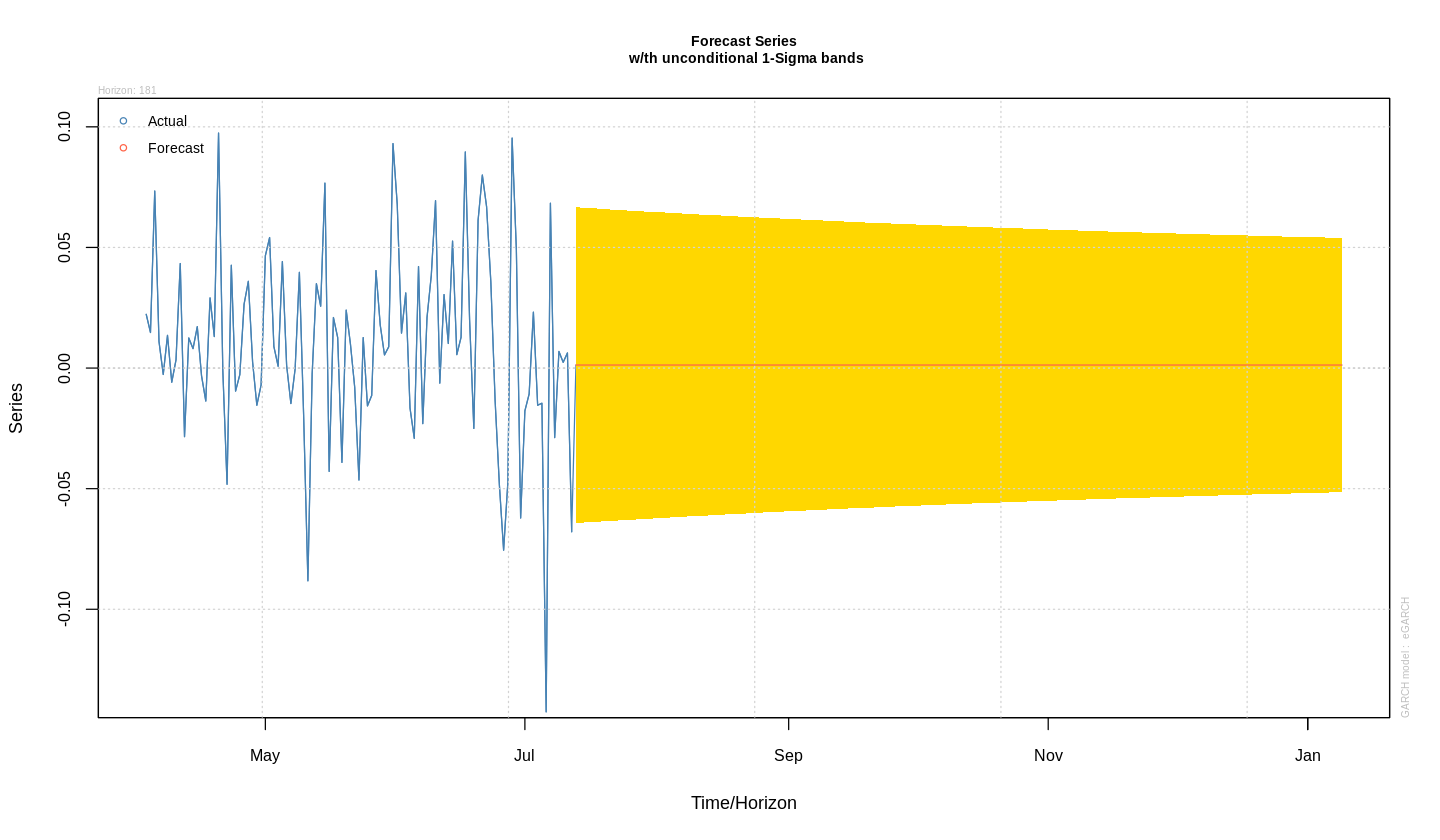

In [29]:
# predicción y test

#df_prices_train <- filter(df_prices, ref.date <= (max(ref.date)-365))                                          

df_prices <- read_rds('data/BTC-GARCH-Data.rds')

library(lubridate)
lag_test = days(last_date - train_date)
n_test = lag_test @ day # cantidad de simulaciones para el forecast (predicción a un año) 

df_test <- df_prices %>% 
  filter(ref.date > train_date)

#ajusto de nuevo el modelo con out.sample para que pueda usarse el forecast (nro de muestras guardadas para test)
garch_test <- ugarchfit(spec = best_spec, 
                           data = df_prices$log_ret, out.sample = n_test) 
                                        
fore = ugarchforecast(garch_test, n.ahead = n_test, n.roll = 1)
#The ability to roll the forecast 1 step at a time is implemented with the n.roll argument which
#controls how many times to roll the n.ahead forecast. Critically, since n.roll depends on data being
#available from which to base the rolling forecast, the ugarchfit function needs to be called with the
#argument out.sample being at least as large as the n.roll argument.
#n.ahead: The forecast horizon.
#n.roll: The no. of rolling forecasts to create beyond the first one.


#fore@model$modeldata$index = df_test$ref.date  # se igualan los ejes de tiempo para las gráficas

plot(fore, which= 1) 

## 3.1 Modelos Estadísticos: Redes Neuronales

In [32]:
#install.packages("quantmod")
#install.packages("tidyquant")
#install.packages("prophet")
#install.packages("TSstudio")
#install.packages("PerformanceAnalytics")




library(astsa)
library(lubridate)
library(xts)
library(keras) # for deep learning
#library(tidyquant)
library(quantmod)



options(repr.plot.width=12, repr.plot.height=7) #ajusta tamaño de graficas


Loading required package: TTR


Attaching package: ‘TTR’


The following object is masked from ‘package:MTS’:

    VMA




In [33]:
# importación de las series desde Yahoo Finance
portfolio_raw <- c("BTC-USD","ETH-USD","TSLA","AAPL","USDT-USD","BNB-USD","^GSPC")
getSymbols(portfolio_raw, src="yahoo", from="2017-07-15")


Warning message:
“BTC-USD contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them.”
Warning message:
“ETH-USD contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them.”
Warning message:
“USDT-USD contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them.”
pausing 1 second between requests for more than 5 symbols

Warning message:
“BNB-USD contains missing values. Some functions will not work if objects contain missing values in the middle of the series. Consider using na.omit(), na.approx(), na.fill(), etc to remove or replace them.”
pausing 1 second between requests for mo

[1] "BTC-USD"  "ETH-USD"  "TSLA"     "AAPL"     "USDT-USD" "BNB-USD"  "^GSPC"

#### Cambio de nombre a series y columnas

In [34]:
btc <- na.omit(`BTC-USD`)
eth <- na.omit(`ETH-USD`)
tsla <- na.omit(TSLA)
aapl <- na.omit(AAPL)
usdt <- na.omit(`USDT-USD`)
bnb  <- na.omit(`BNB-USD`)
sp500 <- na.omit(GSPC)

In [35]:
v_colnames <- c('open','high','low','close','volume','adjusted')

colnames(btc)   <- v_colnames
colnames(eth)   <- v_colnames
colnames(tsla)  <- v_colnames
colnames(aapl)  <- v_colnames
colnames(usdt)  <- v_colnames
colnames(bnb)   <- v_colnames
colnames(sp500) <- v_colnames

btc   <- btc$adjusted
eth   <- eth$adjusted
tsla  <- tsla$adjusted
aapl  <- aapl$adjusted
usdt  <- usdt$adjusted
bnb   <- bnb$adjusted
sp500 <- sp500$adjusted


####  Redes Neuronales: Definición de funciones

In [46]:
#--------------------------------------------------------------------------
# split_train_test
# Crea los conjuntos train/test de acuerdo a la fecha que se le pasa
#--------------------------------------------------------------------------
split_train_test <- function (x, i_fecha='2021-01-27', i_window=3, i_pred=1) {
    window <- i_window
    pred <-  i_pred
    x_train <- x[time(x)<i_fecha]

    n_train <- length(x_train)
    print(n_train)

    X_train <- matrix(,n_train-window-pred+1,window)
    y_train <- matrix(,n_train-window-pred+1,pred)

    for (i in 1:(n_train-window-pred+1)) {
        X_train[i,] <- x_train[i:(i+window-1)]
        y_train[i,] <- x_train[(i+window):(i+window+pred-1)]
    }

    x_test <- x[time(x)>=i_fecha]
    n_test <- length(x_test)

    X_test <- matrix(,n_test-window-pred+1,window)
    y_test <- matrix(,n_test-window-pred+1,pred)

    for (i in 1:(n_test-window-pred+1)) {
        X_test[i,] <- x_test[i:(i+window-1)]
        y_test[i,] <- x_test[(i+window):(i+window+pred-1)]
    }

    X_train <- array(X_train, dim = c(n_train-window-pred+1, window, 1))
    X_test  <- array(X_test,  dim = c(n_test-window-pred+1, window, 1))
    
    return(list('X_train'=X_train,'y_train'=y_train,'X_test'=X_test,'y_test'=y_test))
}






In [47]:
train_nn <- function (i_model, i_loss, i_optimizer, i_metrics, i_epochs, i_split) {
    
#    summary(i_model)
    i_model %>% compile(loss = i_loss, optimizer = i_optimizer, metrics = i_metrics)
    trained_model <- i_model %>% fit(
        x = X_train, # sequence we're using for prediction 
        y = y_train, # sequence we're predicting
        epochs = i_epochs, # how many times we'll look @ the whole dataset
        validation_split = i_split
    ) # how much data to hold out for testing as we go along
    
    return(list('trained_model'=trained_model,'model'=i_model))
    
}

In [48]:
display_results <- function (i_model, i_trained_model) {
    print("Modelo")
    plot(i_trained_model)
    print("Train")    
    y1 <- predict(i_model,X_train)
    tsplot(y_train, col=4, lwd=2)
    lines(y1, col=6, lwd=2)
    
}

In [49]:
calculate_mse <- function(s1, s2) {
    return ( round(mean((s1 - s2)^2)) )
}

#### Definición de variables

In [50]:
v_loss      <- 'mse'
v_optimizer <- 'adam'
v_metrics   <- c('mse')
v_epochs    <- 100
v_split     <- 0.2
v_fecha     <- '2021-01-27'
v_window    <- 3

#### Preprocesamiento

In [51]:
x <- btc

In [52]:
x <- na.omit(x)

#### NN simple con 3 días de ventana

In [53]:
split_train <- split_train_test(x,i_fecha=v_fecha, i_window=v_window)

[1] 1288


In [54]:
X_train <- split_train$X_train
y_train <- split_train$y_train
X_test  <- split_train$X_test
y_test  <- split_train$y_test

In [55]:
# initialize our model
model1 <- keras_model_sequential()

model1 %>%
    layer_flatten(input_shape = dim(X_train)[2:3]) %>%
    layer_dense(units = 64, activation="relu") %>%
    layer_dense(units = 1)

In [56]:
trained_model <- train_nn(model1, v_loss, v_optimizer, v_metrics, v_epochs, v_split)


In [57]:
model1         <- trained_model$model
trained_model1 <- trained_model$trained_model

`geom_smooth()` using formula 'y ~ x'



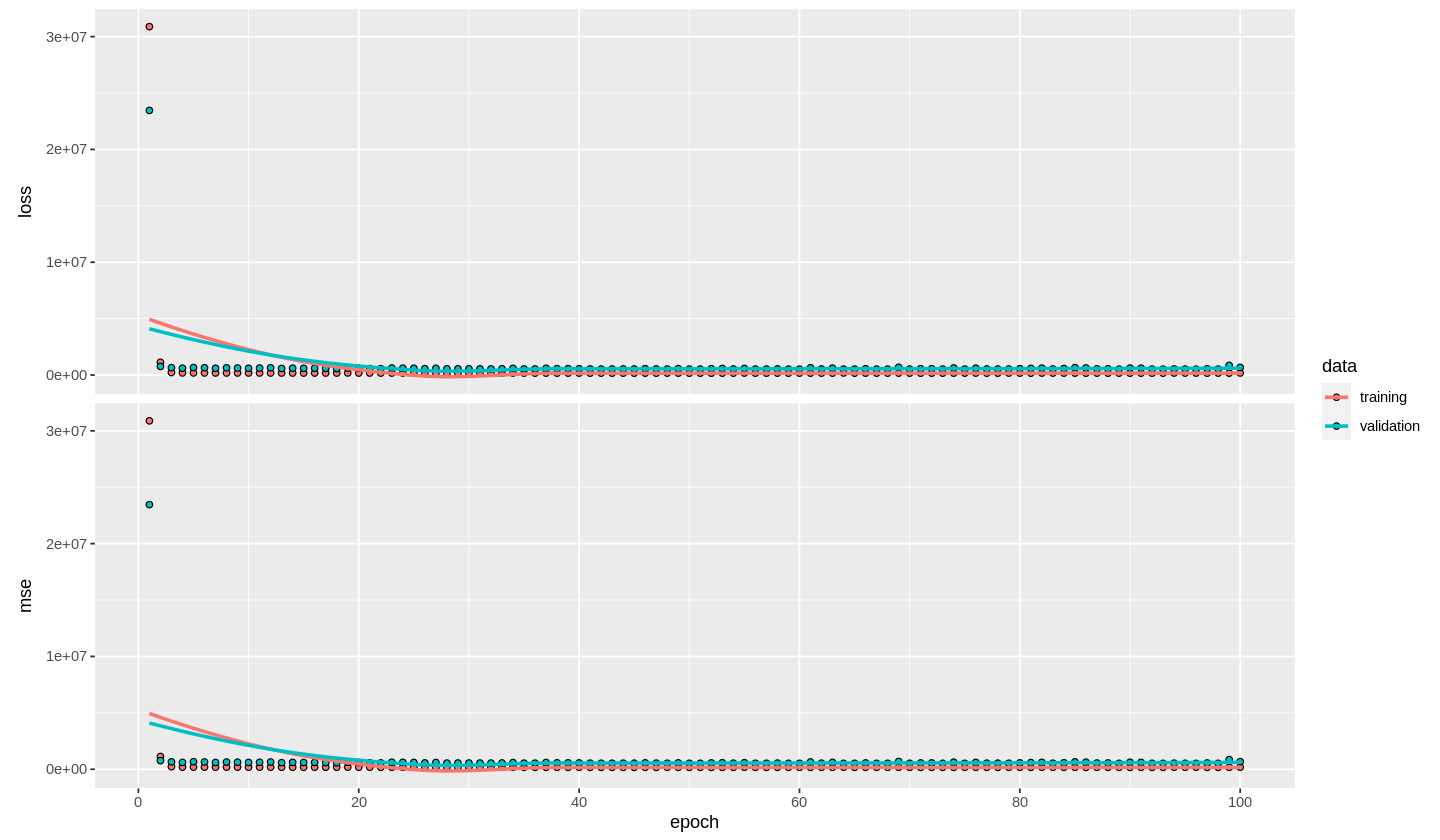

In [58]:
plot(trained_model1)

#### Gráficos de Train

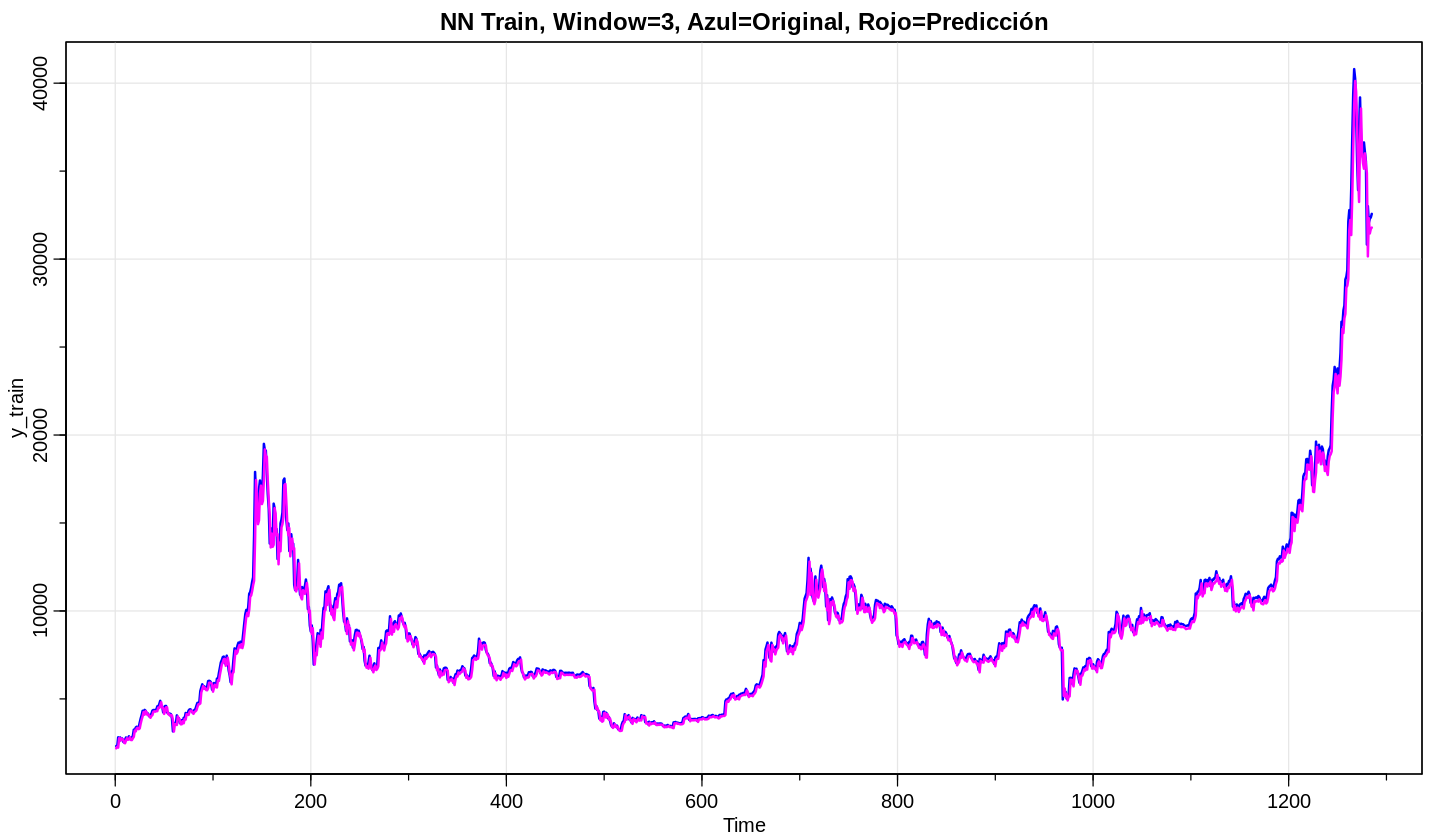

In [59]:
y1 <- predict(model1,X_train)

tsplot(y_train, col=4, lwd=2, main='NN Train, Window=3, Azul=Original, Rojo=Predicción')
axis(1, time(btc) ) # , format(dm$Date, "%b %d"), cex.axis = .7)
lines(y1, col=6, lwd=2)


In [60]:
evaluate(model1,X_train,y_train)

loss      mse 
280324.3 280324.3

Para los datos vistos, el resultado es bueno. Puede ser que exista overfitting aunque se tiene una red sencilla.

#### Gráficos de TEST

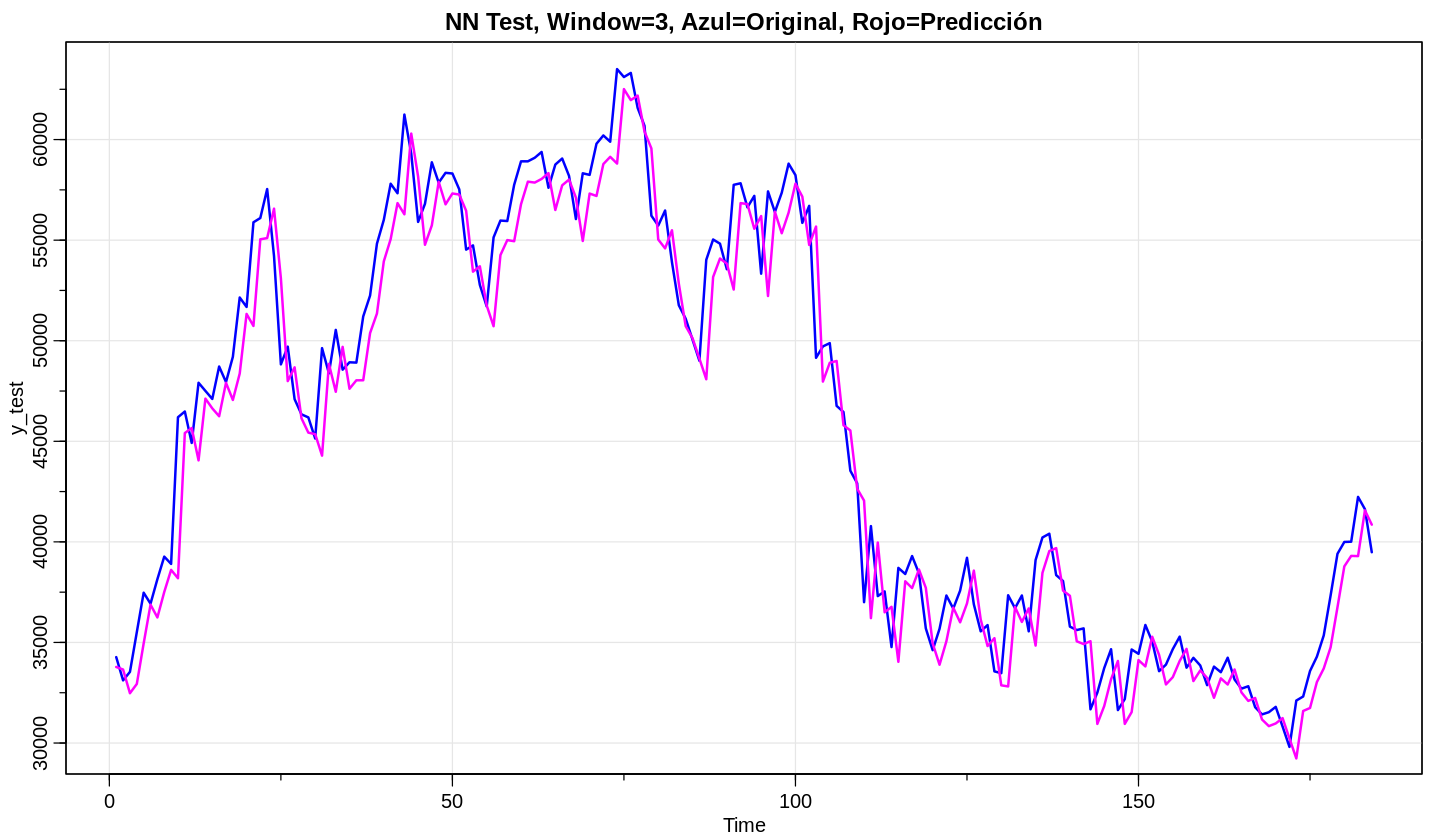

In [61]:
y1_test <- predict(model1,X_test)

tsplot(y_test, col=4, lwd=2, main='NN Test, Window=3, Azul=Original, Rojo=Predicción')
lines(y1_test, col=6, lwd=2)

In [62]:
evaluate(model1,X_test,y_test)

loss     mse 
4759870 4759870

Lo que se ve es que para test lo que 'predice' es la serie con un lag de un día.

#### Red simple con ventana=20

In [63]:
split_train <- split_train_test(x,i_fecha=v_fecha, i_window=20)

X_train <- split_train$X_train
y_train <- split_train$y_train
X_test  <- split_train$X_test
y_test  <- split_train$y_test

[1] 1288


In [64]:
# initialize our model
model2 <- keras_model_sequential()

model2 %>%
    layer_flatten(input_shape = dim(X_train)[2:3]) %>%
    layer_dense(units = 64, activation="relu") %>%
    layer_dense(units = 1)

In [65]:
trained_model <- train_nn(model2, v_loss, v_optimizer, v_metrics, v_epochs, v_split)

In [66]:
model2         <- trained_model$model
trained_model2 <- trained_model$trained_model

`geom_smooth()` using formula 'y ~ x'



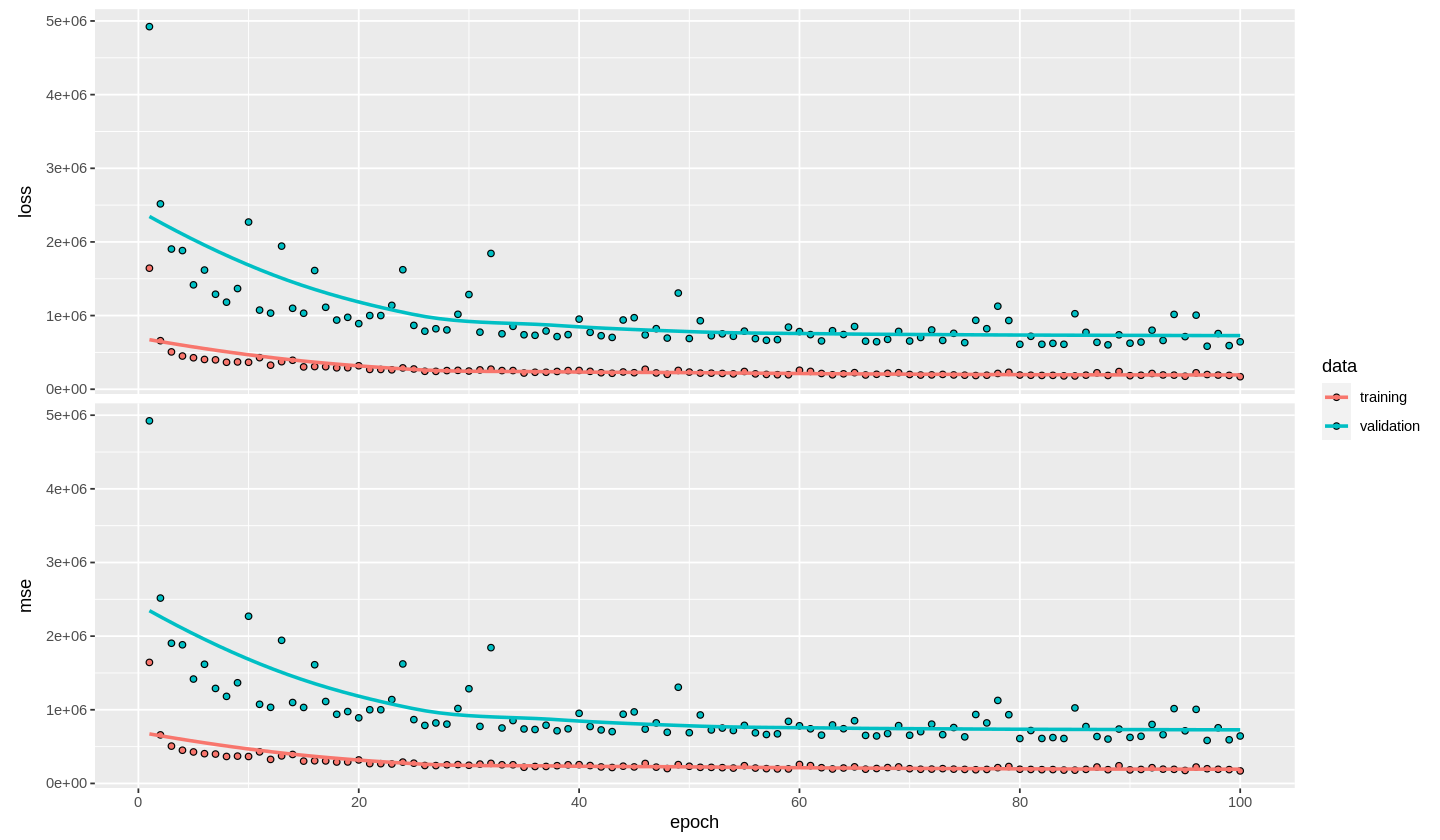

In [67]:
plot(trained_model2)

#### Gráficos de TRAIN

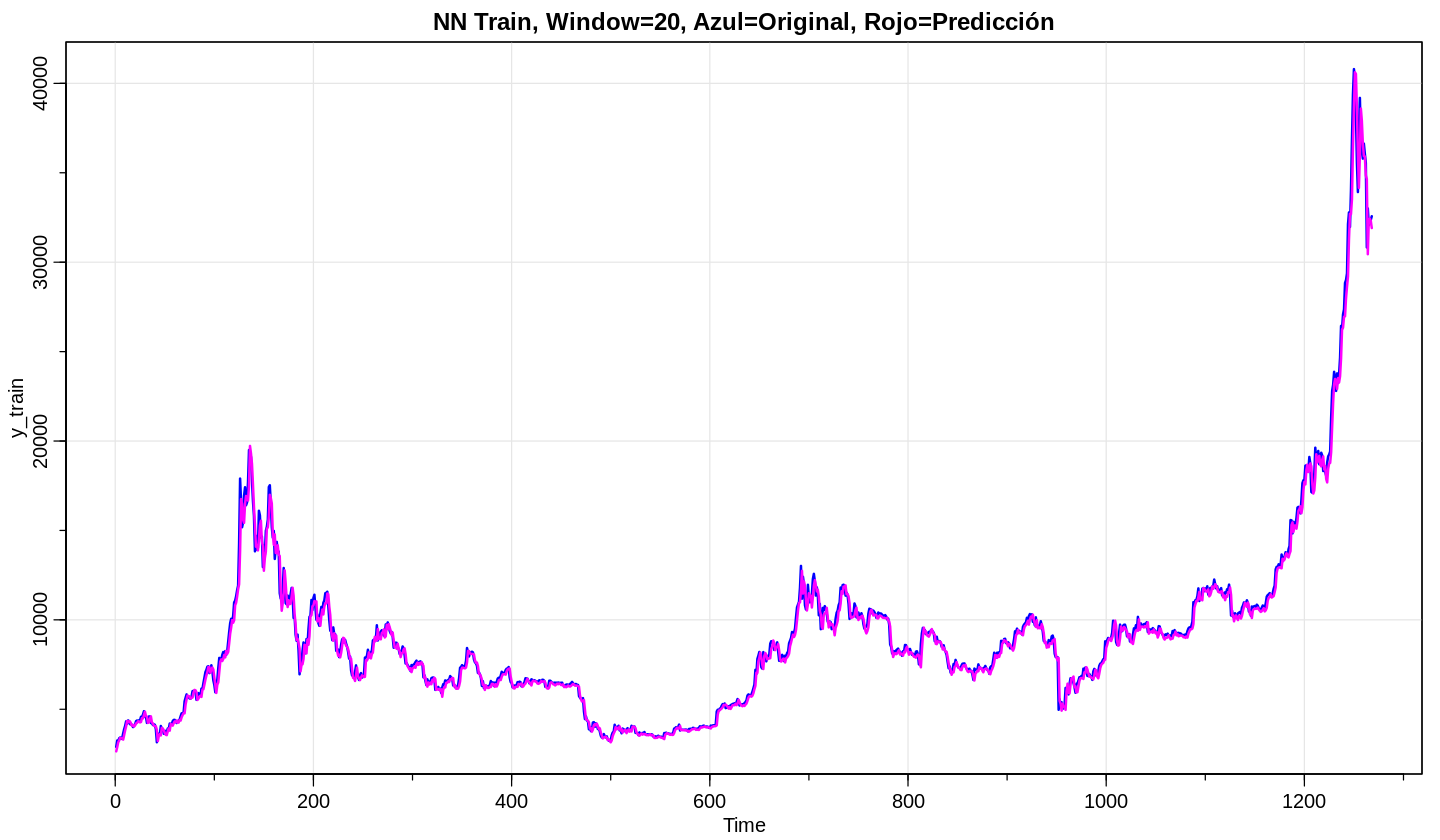

In [68]:
y2 <- predict(model2,X_train)

tsplot(y_train, col=4, lwd=2, main='NN Train, Window=20, Azul=Original, Rojo=Predicción')
lines(y2, col=6, lwd=2)

In [69]:
evaluate(model2,X_train,y_train)

loss      mse 
265414.4 265414.4

#### Gráficos de TEST

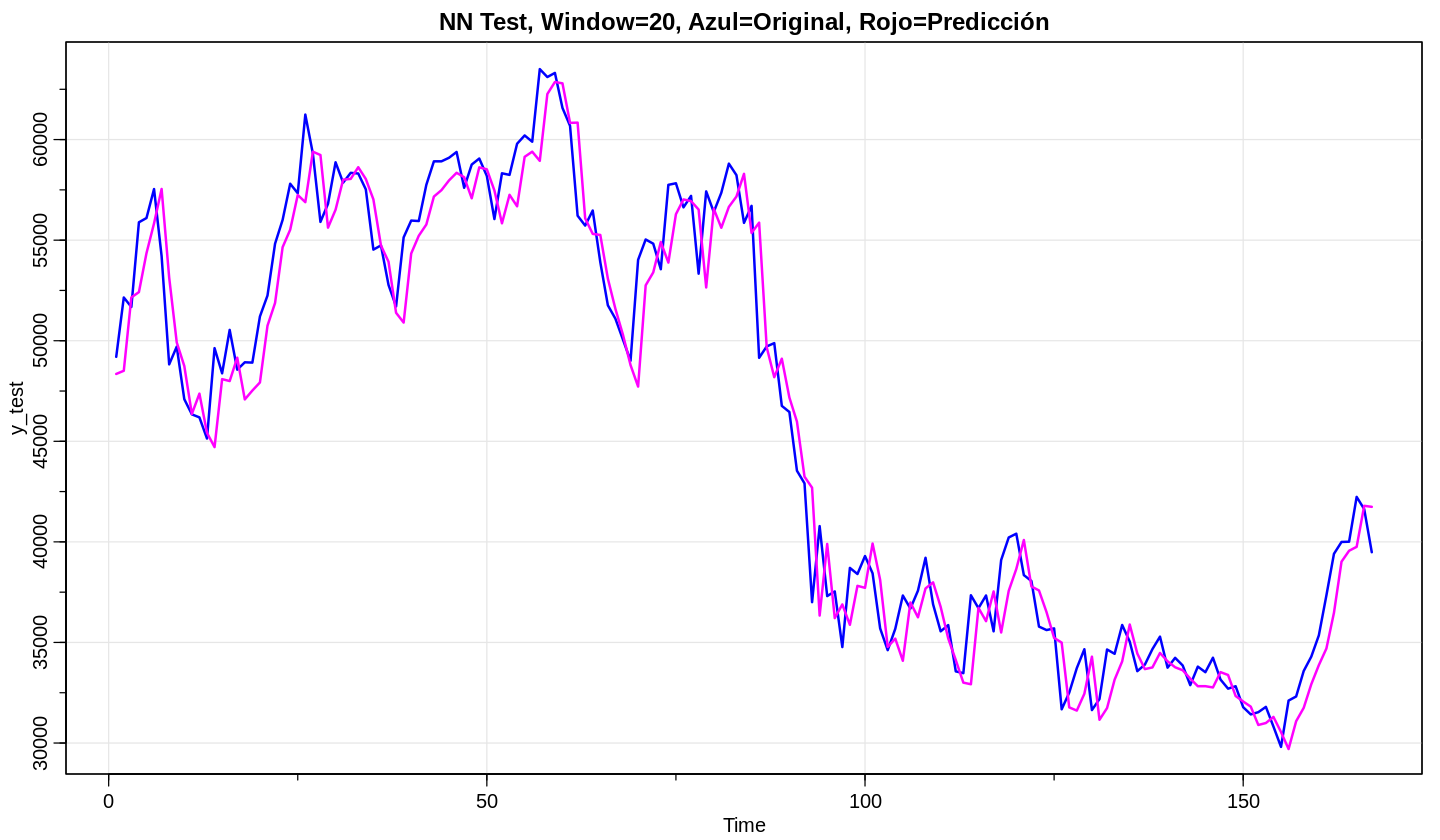

In [70]:
y2_test <- predict(model2,X_test)

tsplot(y_test, col=4, lwd=2,main='NN Test, Window=20, Azul=Original, Rojo=Predicción')
lines(y2_test, col=6, lwd=2)

In [71]:
evaluate(model2,X_test,y_test)

loss     mse 
4264098 4264098

El error con 20 días aumenta y sigue teniendo forma de la serie con diferencia de un día.

#### Cálculo de Error si asumimos que el valor de hoy es igual de mañana

In [72]:
# La serie con lag de 1 día

p1 <- y_test[1:length(y_test)-1]
p2 <- y_test[2:length(y_test)]

In [73]:
calculate_mse(p1,p2)

[1] 4008961

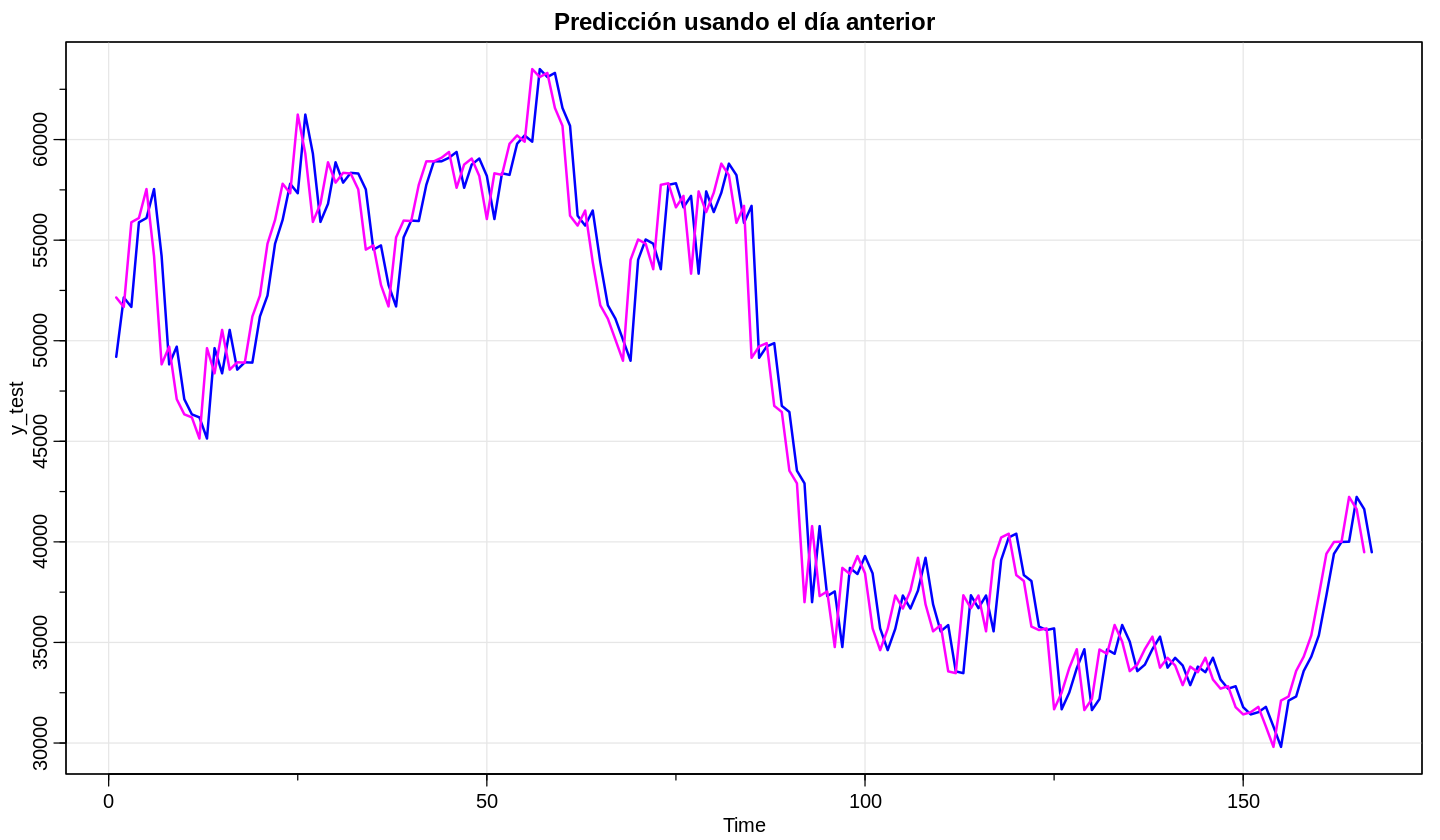

In [74]:
tsplot(y_test, col=4, lwd=2, main="Predicción usando el día anterior")
lines(p2, col=6, lwd=2)

Con esta red, resulta mejor predecir con el valor de ayer que hacer todo el entrenamiento.

#### RNN NN

In [75]:
split_train <- split_train_test(x,i_fecha=v_fecha)

X_train <- split_train$X_train
y_train <- split_train$y_train
X_test  <- split_train$X_test
y_test  <- split_train$y_test

[1] 1288


In [76]:
# initialize our model
model3 <- keras_model_sequential()

model3 %>%
    #layer_simple_rnn(input_shape = dim(X_train)[2:3], units = 8, activation="relu") %>%
    layer_simple_rnn(input_shape = dim(X_train)[2:3], units = 64, activation="relu") %>%
    layer_dense(units = 1)

In [77]:
trained_model <- train_nn(model3, v_loss, v_optimizer, v_metrics, v_epochs, v_split)


In [78]:
model3         <- trained_model$model
trained_model3 <- trained_model$trained_model

`geom_smooth()` using formula 'y ~ x'



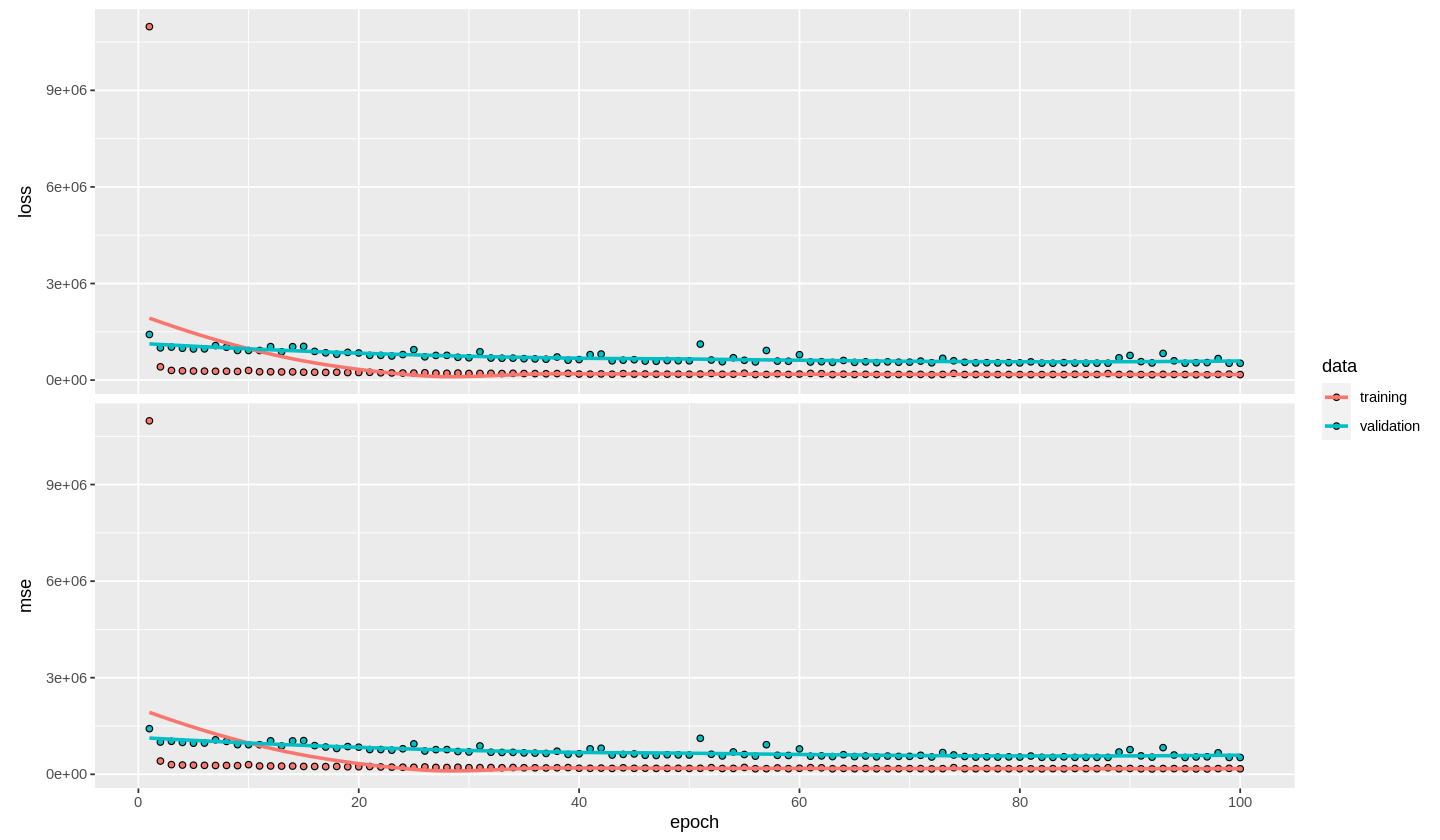

In [79]:
plot(trained_model3)

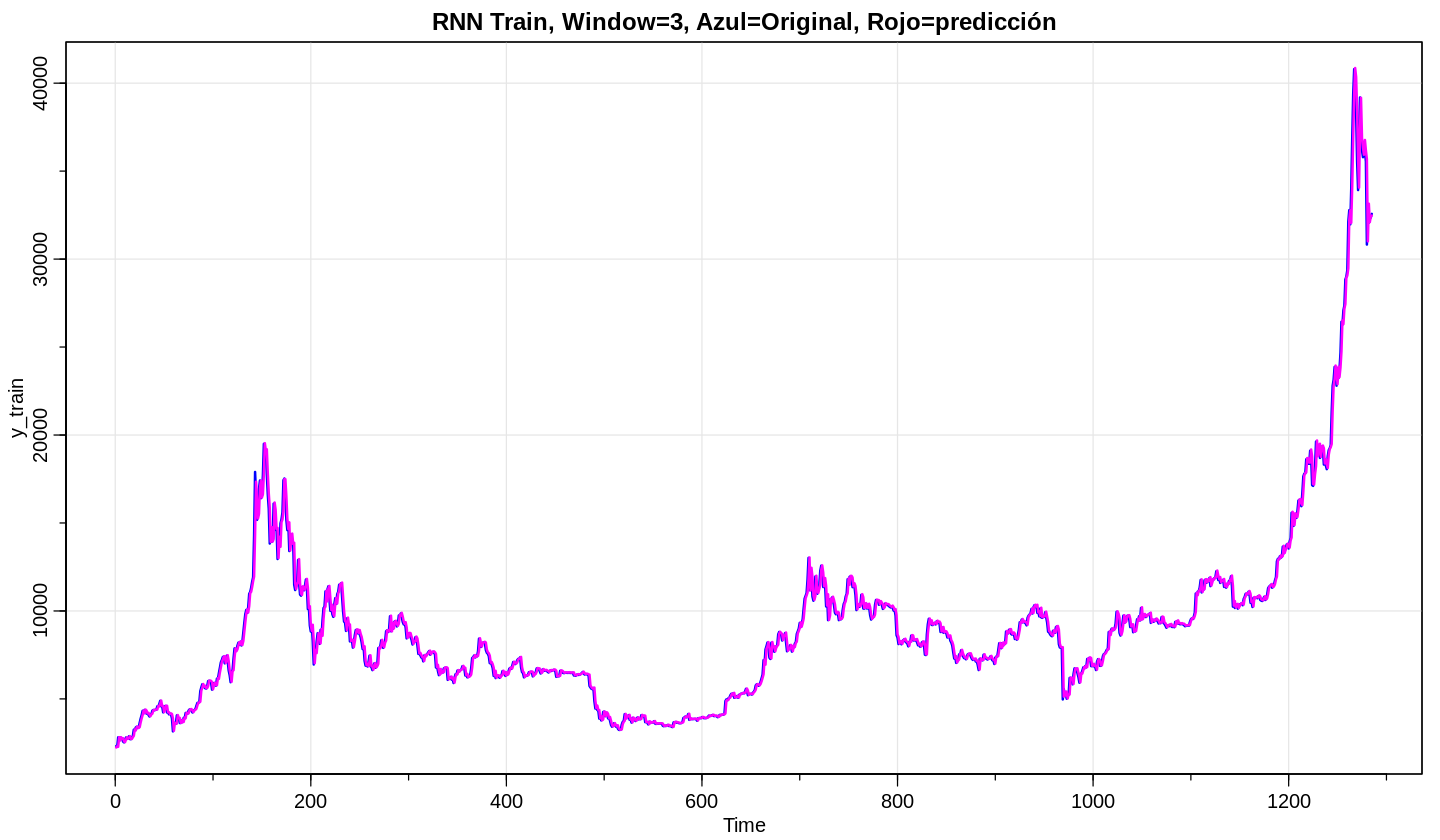

In [80]:
y3 = predict(model3,X_train)

tsplot(y_train, col=4, lwd=2, main="RNN Train, Window=3, Azul=Original, Rojo=predicción")
lines(y3, col=6, lwd=2)

In [81]:
evaluate(model3, X_train, y_train)


loss      mse 
233897.1 233897.1

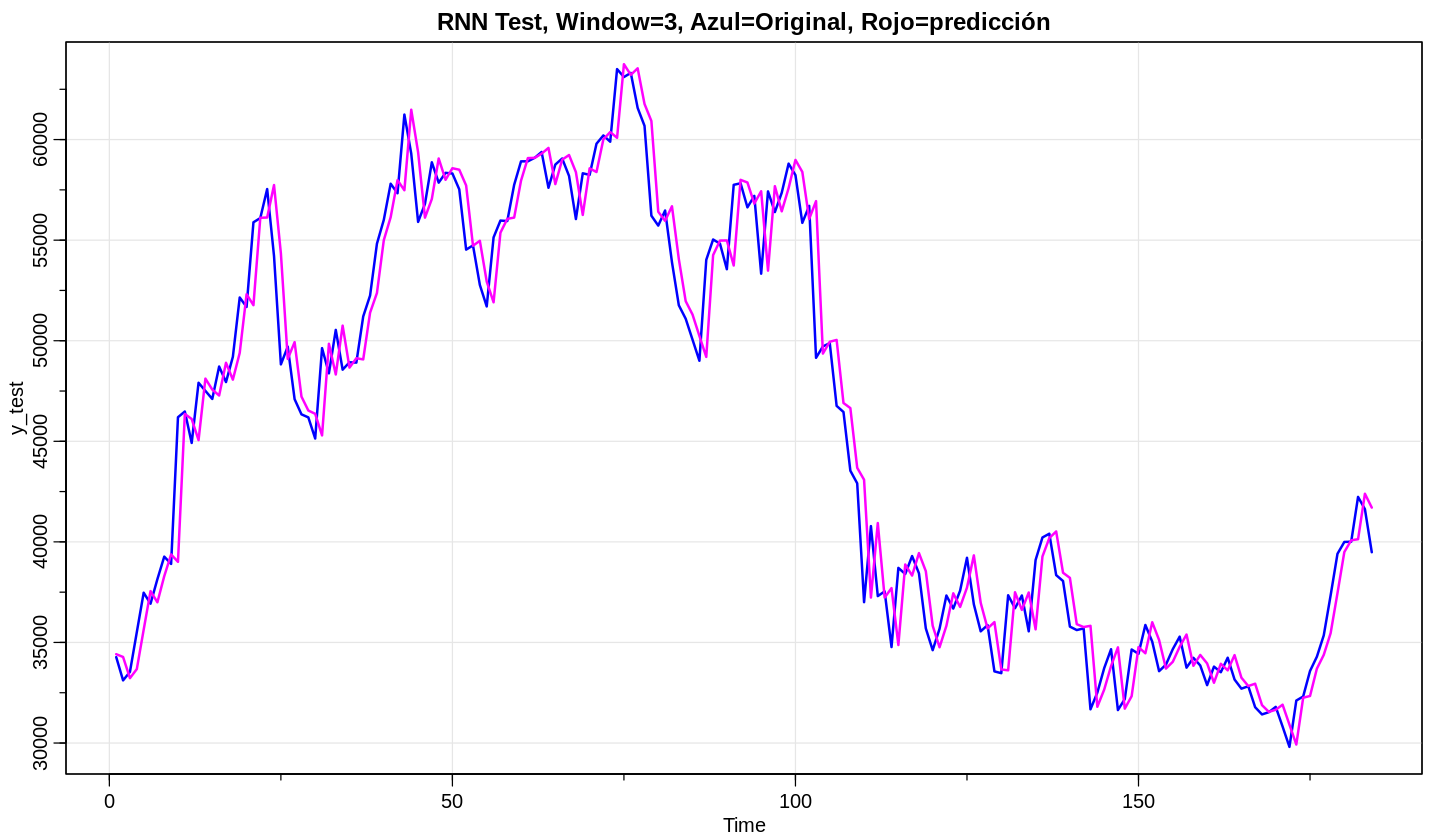

In [82]:
y3_test = predict(model3,X_test)

tsplot(y_test, col=4, lwd=2, main="RNN Test, Window=3, Azul=Original, Rojo=predicción")
lines(y3_test, col=6, lwd=2)

In [ ]:
evaluate(model3, X_test, y_test)

Se ve el mismo comportamiento que los anteriores.

#### LSTM NN

In [83]:
# initialize our model
model4 <- keras_model_sequential()


model4 %>%
    layer_dense(input_shape = dim(X_train)[2:3], units = 8, activation = "relu") %>%
    layer_lstm(units = 64, activation="relu") %>%
    layer_dense(units = 64, activation="relu") %>%
    layer_dense(units = 1)

In [84]:
trained_model <- train_nn(model4, v_loss, v_optimizer, v_metrics, v_epochs, v_split)


In [85]:
model4         <- trained_model$model
trained_model4 <- trained_model$trained_model

`geom_smooth()` using formula 'y ~ x'



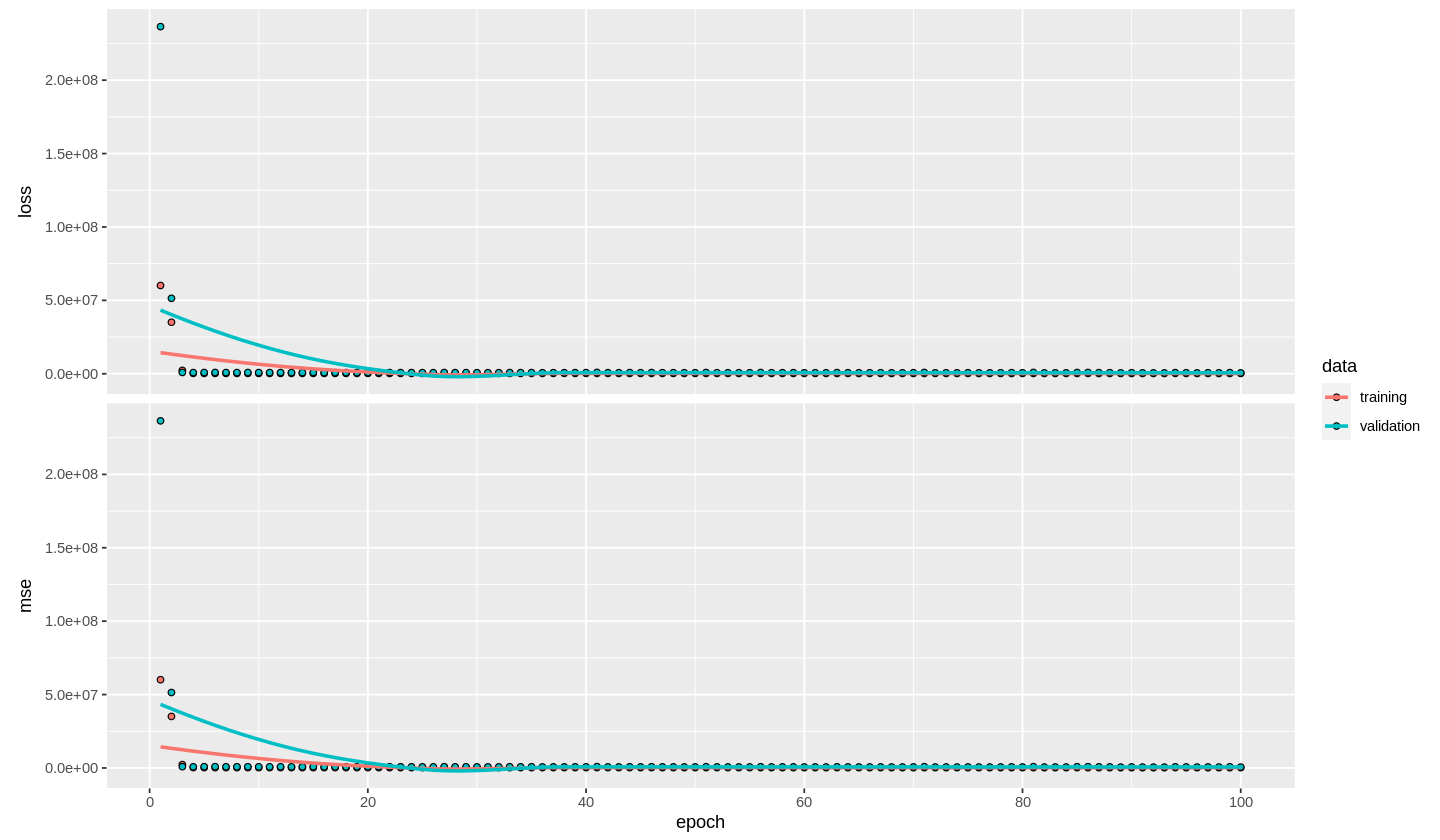

In [86]:
plot(trained_model4)

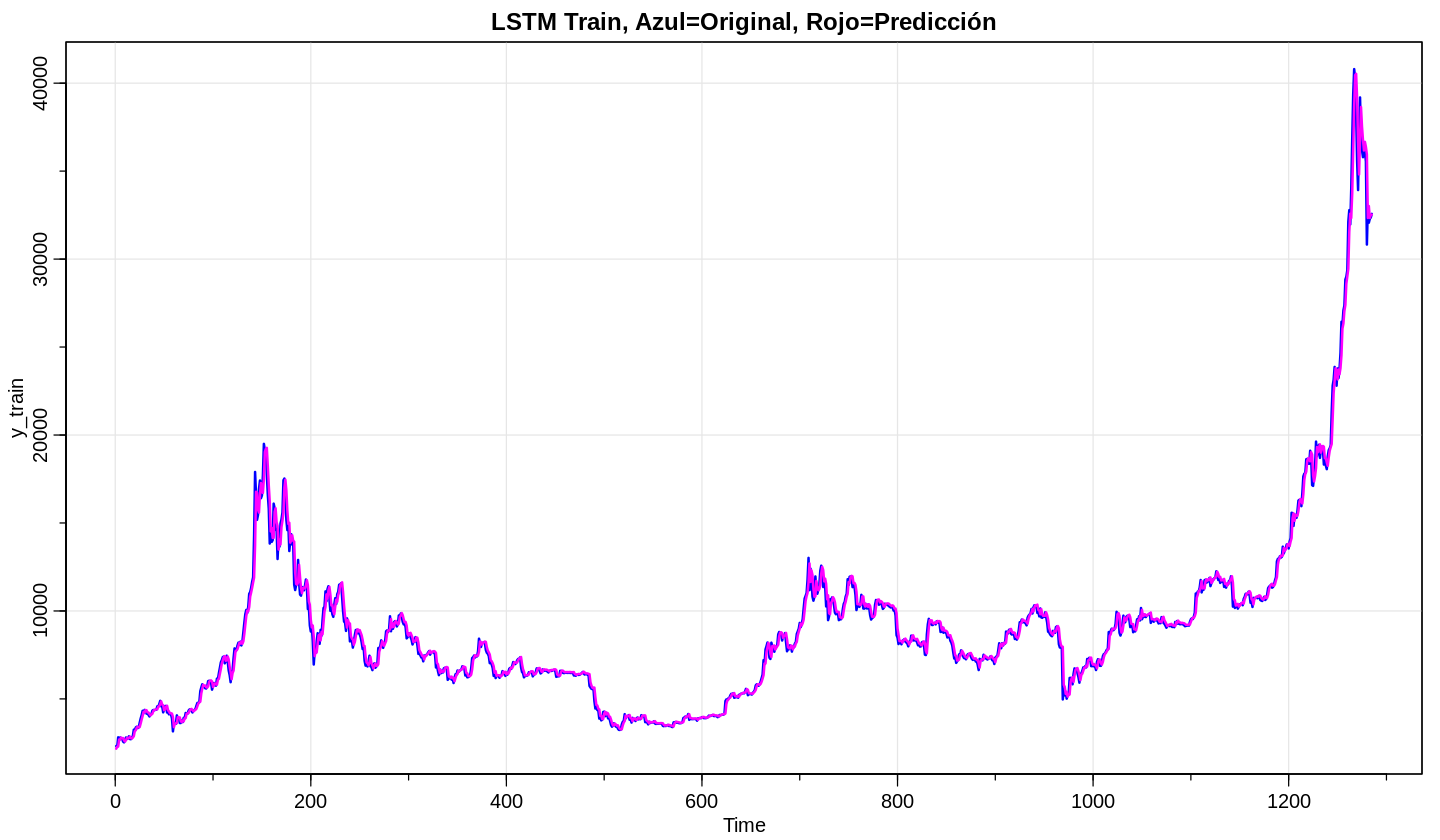

In [87]:
y4 = predict(model4,X_train)

tsplot(y_train, col=4, lwd=2, main='LSTM Train, Azul=Original, Rojo=Predicción')
lines(y4, col=6, lwd=2)

In [88]:
evaluate(model4, X_train, y_train)

loss      mse 
264395.2 264395.2

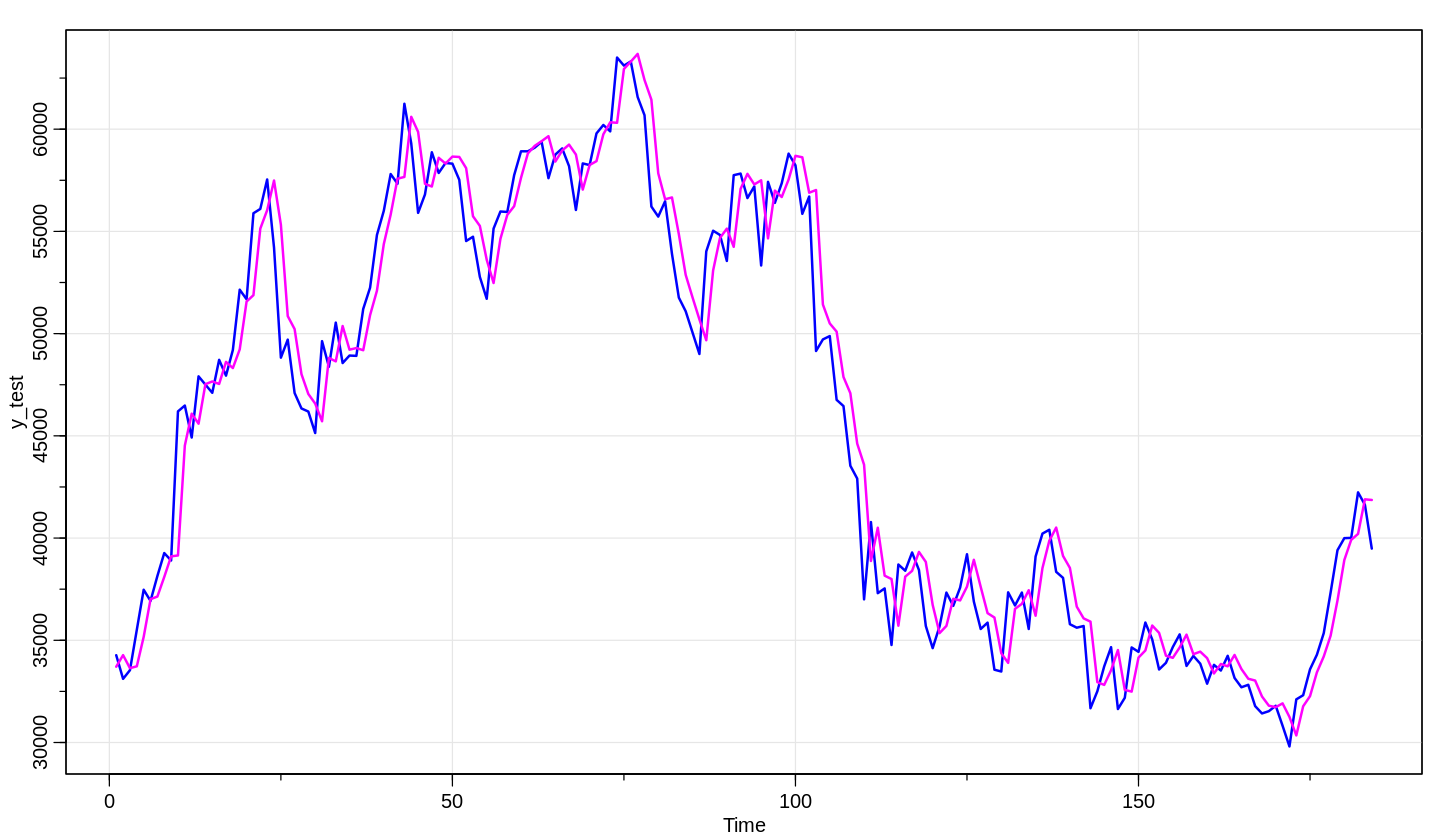

In [89]:
y4_test <- predict(model4,X_test, main='LSTM Test, Azul=Original, Rojo=Predicción')

tsplot(y_test, col=4, lwd=2)
lines(y4_test, col=6, lwd=2)

In [90]:
evaluate(model4,X_test,y_test)

loss     mse 
4273145 4273145

Al igual que las anteriores, la predicción para los datos no vistos es de la serie original con un lag de día.

#### Predicción con otras series

In [92]:
#algo <- btc[time(btc)  %in%  c('2021-01-01','2021-01-02'),]
btc2 <- btc[time(aapl)]
eth2 <- eth[time(aapl)]
bnb2 <- bnb[time(aapl)]

In [93]:
v_colX <- c('aapl','tsla')
v_colY <- c('btc')

In [94]:
x2 <- na.omit( merge(aapl,tsla,eth2,bnb2,sp500,btc2) )

v_colnames2 <- c('aapl','tsla','eth','bnb','sp500','btc')
colnames(x2) <- v_colnames2


In [95]:
na_count <-sapply(x2, function(y) sum(length(which(is.na(y)))))


In [96]:
na_count

aapl  tsla   eth   bnb sp500   btc 
    0     0     0     0     0     0

In [97]:
x2_train <- x2[time(x2) < v_fecha, v_colX]
y2_train <- x2[time(x2) < v_fecha, v_colY]

x2_test <- x2[time(x2) >= v_fecha, v_colX]
y2_test <- x2[time(x2) >= v_fecha, v_colY]



In [98]:
X_train <- coredata(x2_train)
y_train <- coredata(y2_train)

X_test <- coredata(x2_test)
y_test <- coredata(y2_test)

X_train <- array(X_train, dim = c(dim(X_train))) 
X_test  <- array(X_test, dim = c(dim(X_test)))


In [99]:
# initialize our model
model5 <- keras_model_sequential()

model5 %>%
    layer_flatten(input_shape = ncol(X_train)) %>%
    layer_dense(units = 256, activation="relu") %>%
    layer_dense(units = 256, activation="relu") %>%
    layer_dense(units = 256, activation="relu") %>%
    layer_dense(units = 1)

In [100]:
summary(model5)

Model: "sequential_4"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
flatten_2 (Flatten)                 (None, 2)                       0           
________________________________________________________________________________
dense_8 (Dense)                     (None, 256)                     768         
________________________________________________________________________________
dense_9 (Dense)                     (None, 256)                     65792       
________________________________________________________________________________
dense_10 (Dense)                    (None, 256)                     65792       
________________________________________________________________________________
dense_11 (Dense)                    (None, 1)                       257         
Total params: 132,609
Trainable params: 132,609
Non-trainable params: 0
_______________

In [101]:
trained_model <- train_nn(model5, v_loss, v_optimizer, v_metrics, v_epochs, v_split)

In [102]:
model5         <- trained_model$model
trained_model5 <- trained_model$trained_model

`geom_smooth()` using formula 'y ~ x'



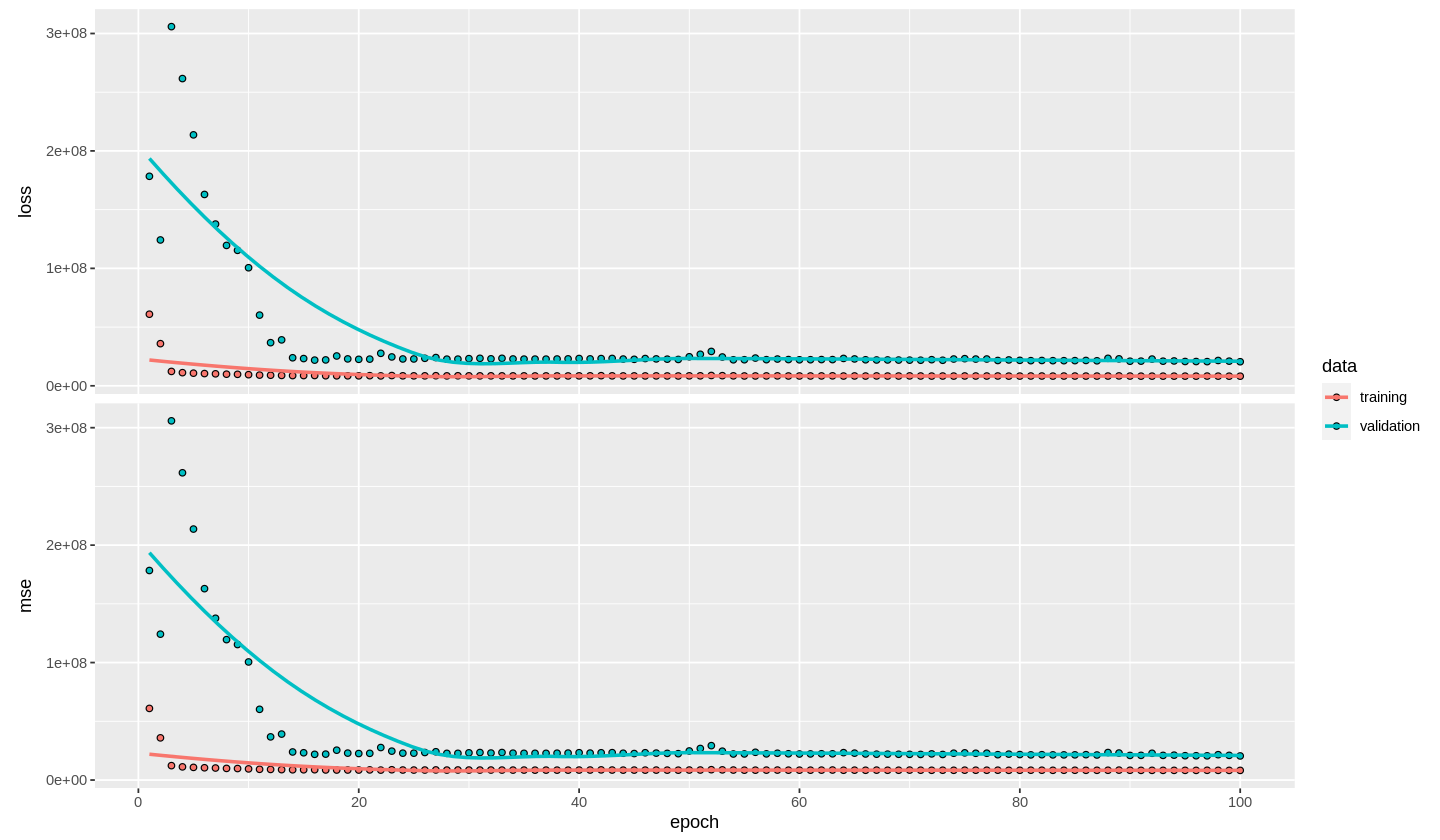

In [103]:
plot(trained_model5)

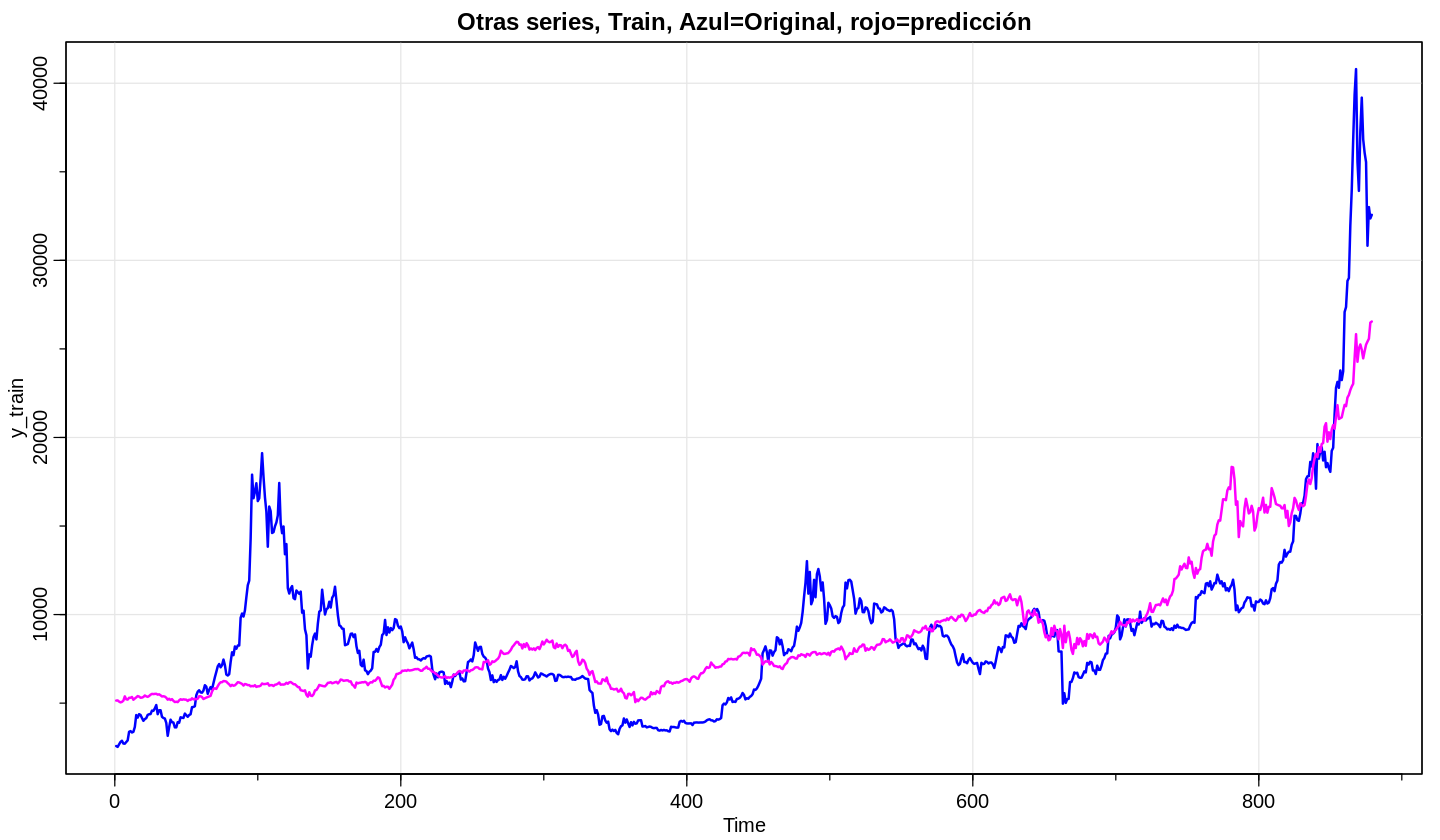

In [104]:
y5 <- predict(model5,X_train )

tsplot(y_train, col=4, lwd=2,main="Otras series, Train, Azul=Original, rojo=predicción")
lines(y5, col=6, lwd=2)

In [105]:
evaluate(model5, X_train, y_train)

loss      mse 
10616846 10616846

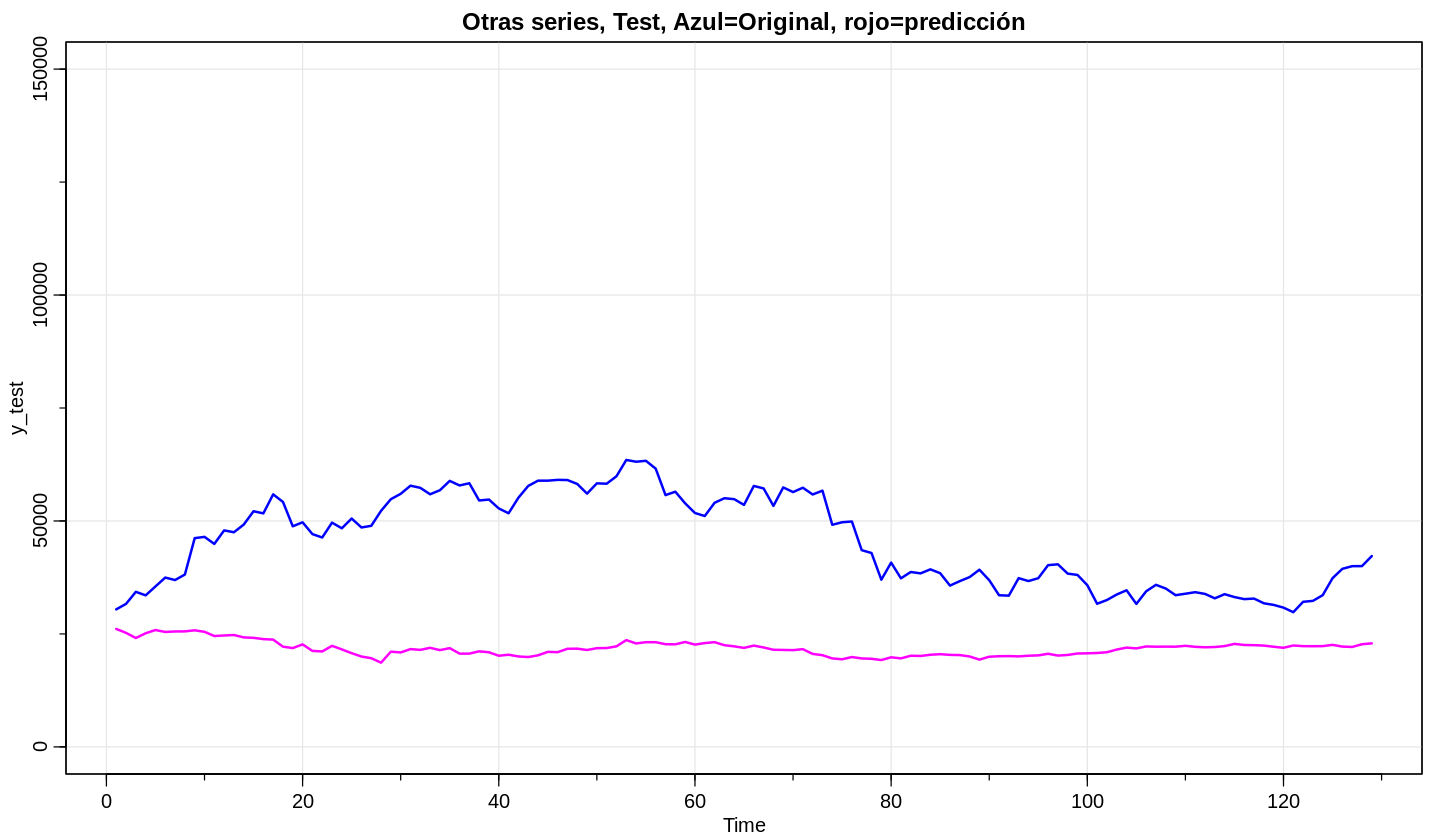

In [106]:
y5_test <- predict(model5,X_test)

tsplot(y_test, col=4, lwd=2, ylim=c(0,150000),main="Otras series, Test, Azul=Original, rojo=predicción")
lines(y5_test, col=6, lwd=2)

In [107]:
evaluate(model5, X_test, y_test)

loss       mse 
668213504 668213504

#### Modelo con 5 series predictores

In [108]:
v_colX <- c('aapl','tsla','eth','bnb','sp500')
v_colY <- c('btc')

In [109]:
x2 <- na.omit( merge(aapl,tsla,eth2,bnb2,sp500,btc2) )

v_colnames2 <- c('aapl','tsla','eth','bnb','sp500','btc')
colnames(x2) <- v_colnames2

In [110]:
x2_train <- x2[time(x2) < v_fecha, v_colX]
y2_train <- x2[time(x2) < v_fecha, v_colY]

x2_test <- x2[time(x2) >= v_fecha, v_colX]
y2_test <- x2[time(x2) >= v_fecha, v_colY]



In [111]:
X_train <- coredata(x2_train)
y_train <- coredata(y2_train)

X_test <- coredata(x2_test)
y_test <- coredata(y2_test)

X_train <- array(X_train, dim = c(dim(X_train))) 
X_test  <- array(X_test, dim = c(dim(X_test)))

In [112]:
# initialize our model
model6 <- keras_model_sequential()

model6 %>%
    layer_flatten(input_shape = ncol(X_train)) %>%
    layer_dense(units = 256, activation="relu") %>%
    layer_dense(units = 256, activation="relu") %>%
    layer_dense(units = 256, activation="relu") %>%
    layer_dense(units = 1)

In [113]:
summary(model6)

Model: "sequential_5"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
flatten_3 (Flatten)                 (None, 5)                       0           
________________________________________________________________________________
dense_12 (Dense)                    (None, 256)                     1536        
________________________________________________________________________________
dense_13 (Dense)                    (None, 256)                     65792       
________________________________________________________________________________
dense_14 (Dense)                    (None, 256)                     65792       
________________________________________________________________________________
dense_15 (Dense)                    (None, 1)                       257         
Total params: 133,377
Trainable params: 133,377
Non-trainable params: 0
_______________

In [114]:
trained_model <- train_nn(model6, v_loss, v_optimizer, v_metrics, v_epochs, v_split)

In [115]:
model6         <- trained_model$model
trained_model6 <- trained_model$trained_model

`geom_smooth()` using formula 'y ~ x'



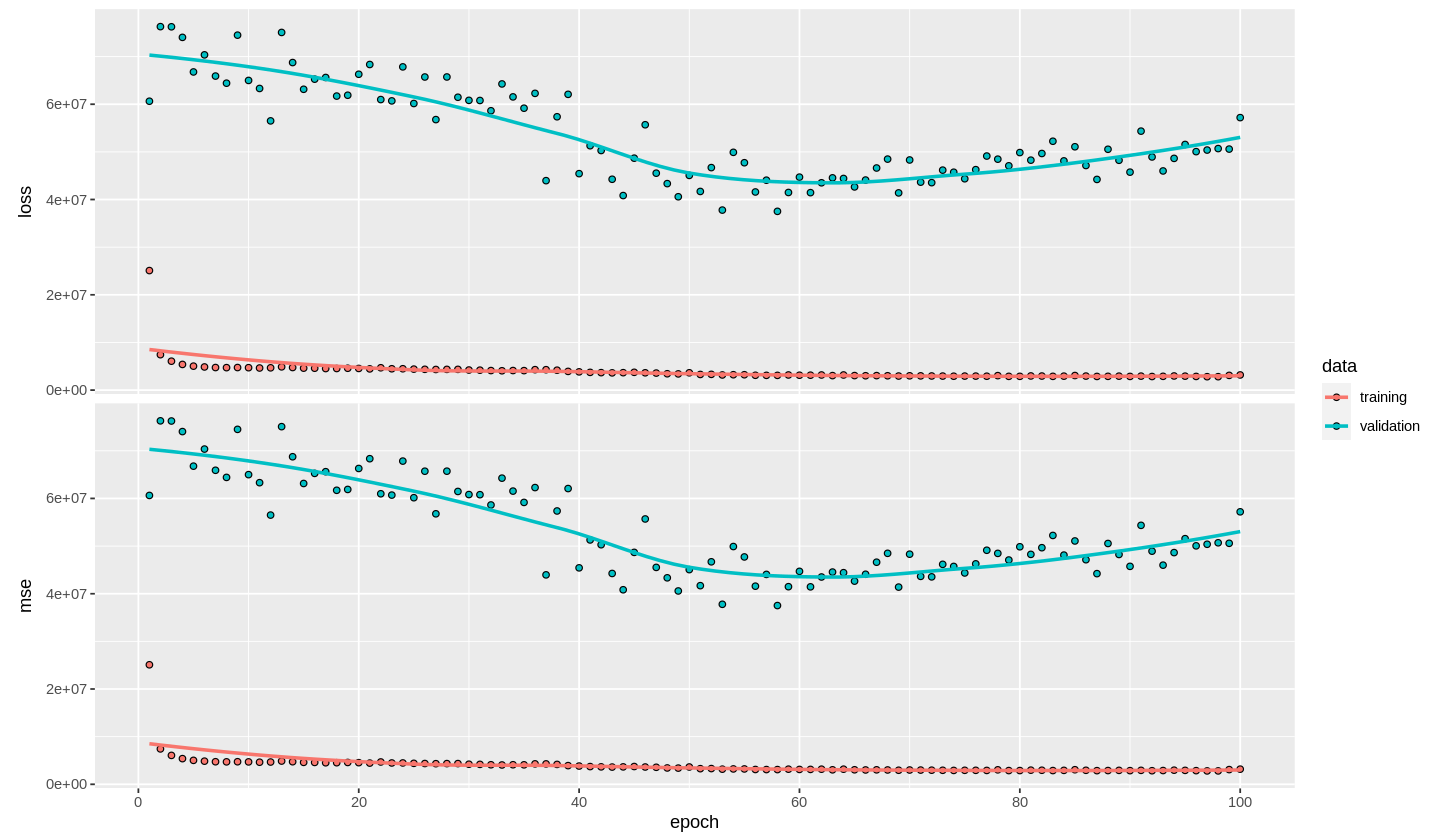

In [116]:
plot(trained_model6)

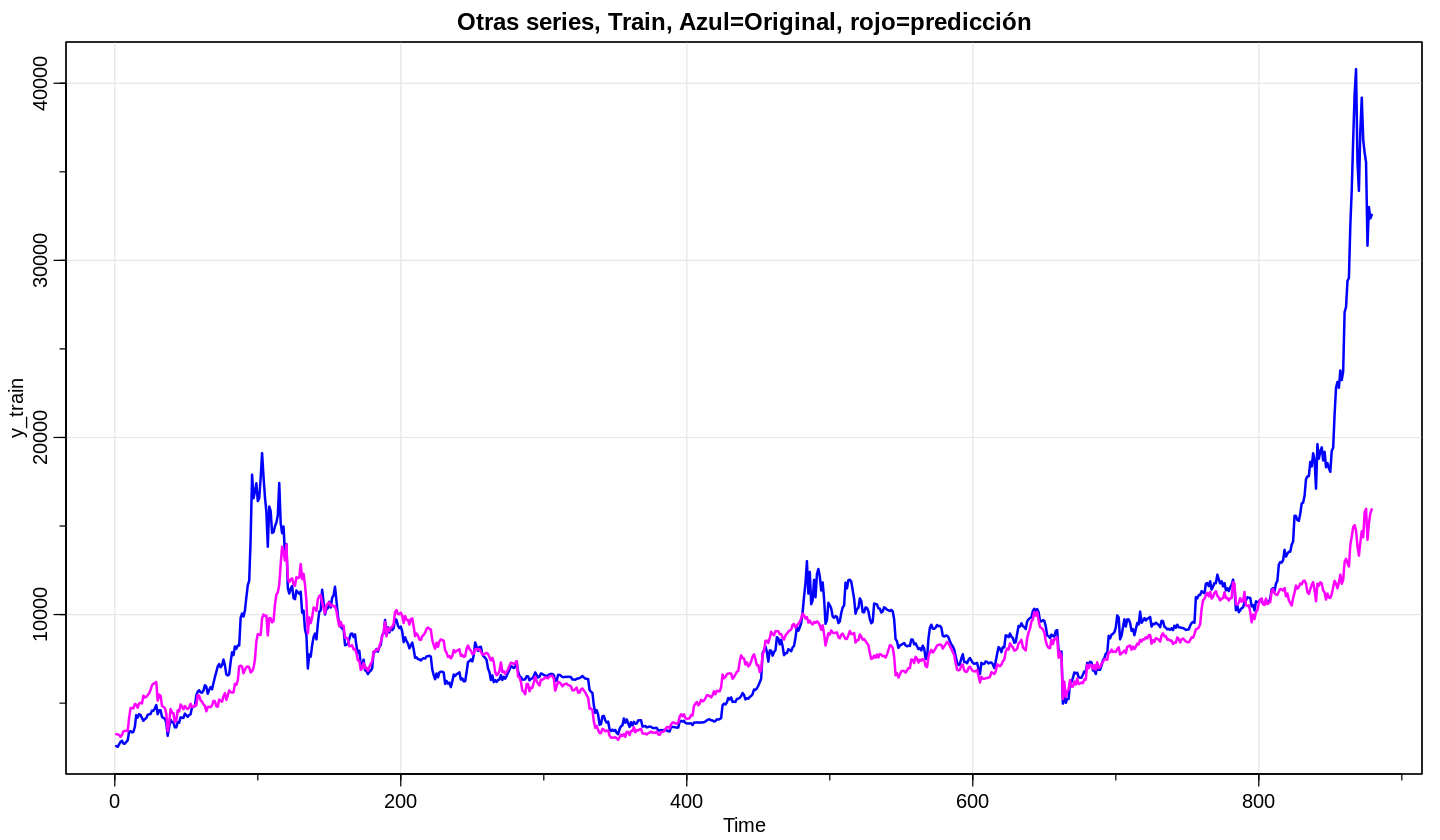

In [117]:
y6 <- predict(model6,X_train )

tsplot(y_train, col=4, lwd=2,main="Otras series, Train, Azul=Original, rojo=predicción")
lines(y6, col=6, lwd=2)

In [118]:
evaluate(model6, X_train, y_train)

loss      mse 
13768886 13768886

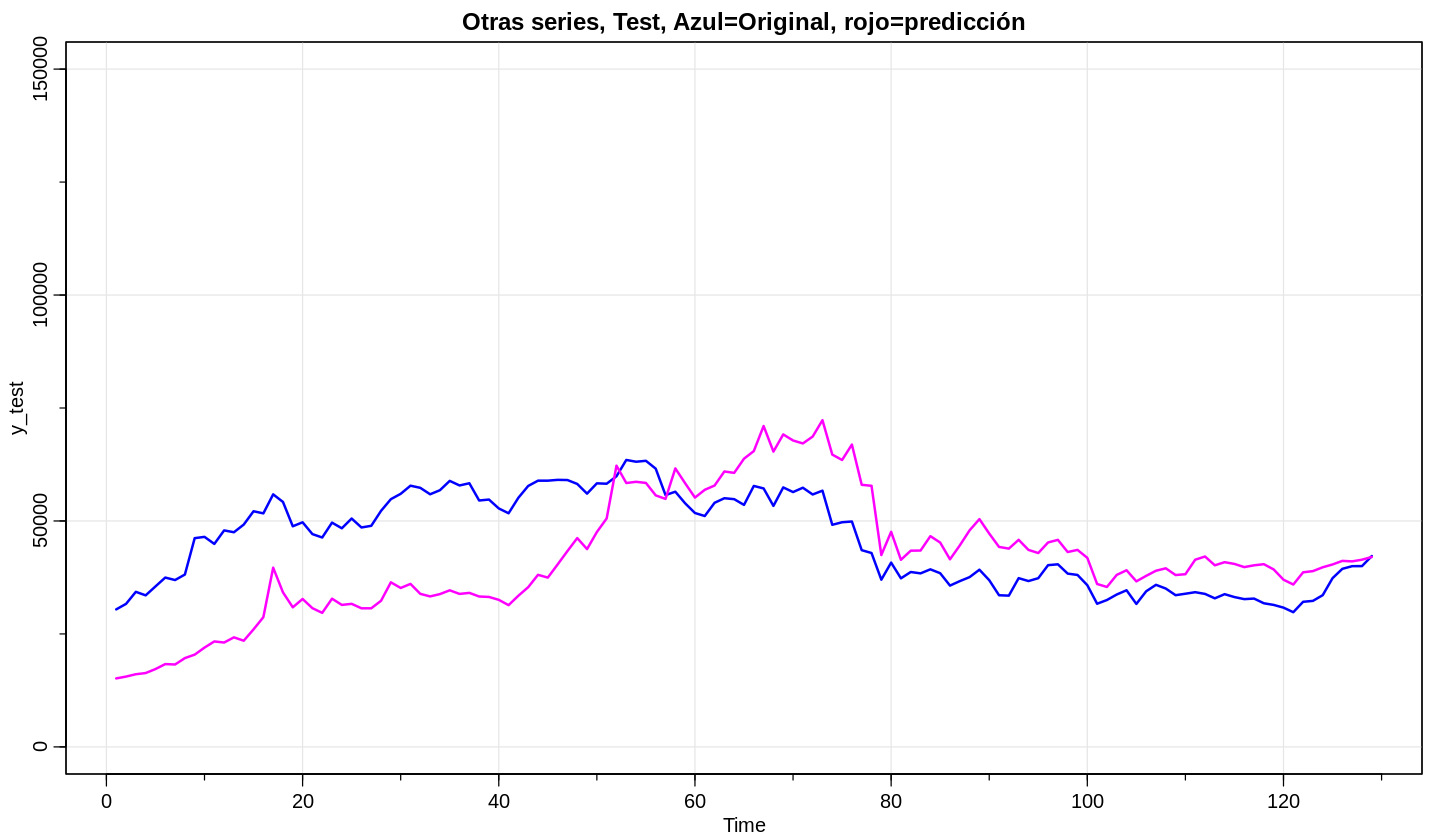

In [119]:
y6_test <- predict(model6,X_test)

tsplot(y_test, col=4, lwd=2, ylim=c(0,150000),main="Otras series, Test, Azul=Original, rojo=predicción")
lines(y6_test, col=6, lwd=2)

In [120]:
evaluate(model6, X_test, y_test)

loss       mse 
194833984 194833984

Con 5 series mejora respecto a 2 pero sigue teniendo más error que la predicción simple del día antes.

### Prueba inconclusas

##### GRU NN

In [121]:
split_train <- split_train_test(x,i_fecha=v_fecha)

X_train <- split_train$X_train
y_train <- split_train$y_train
X_test  <- split_train$X_test
y_test  <- split_train$y_test

[1] 1288


In [122]:
head(X_train)

[1] 1998.86 1929.82 2228.41 2318.88 2273.43 2817.60

In [123]:
# initialize our model
model6 <- keras_model_sequential()

model6 %>%
    layer_dense(input_shape = dim(X_train)[2:3], units = 128, activation = "relu") %>%
    layer_gru(units = 128, activation="tanh") %>%
    layer_dense(units = 1)

In [124]:
summary(model6)

Model: "sequential_6"
________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_16 (Dense)                    (None, 3, 128)                  256         
________________________________________________________________________________
gru (GRU)                           (None, 128)                     98688       
________________________________________________________________________________
dense_17 (Dense)                    (None, 1)                       129         
Total params: 99,073
Trainable params: 99,073
Non-trainable params: 0
________________________________________________________________________________


In [125]:
model6 %>% compile(loss = 'mse', 
                  optimizer = 'adam', 
                  metrics = c('mse'))

In [126]:
trained_model6 <- model6 %>% fit(
    x = X_train, # sequence we're using for prediction 
    y = y_train, # sequence we're predicting
    epochs = 50, # how many times we'll look @ the whole dataset
    validation_split = 0.1) # how much data to hold out for testing as we go along


`geom_smooth()` using formula 'y ~ x'



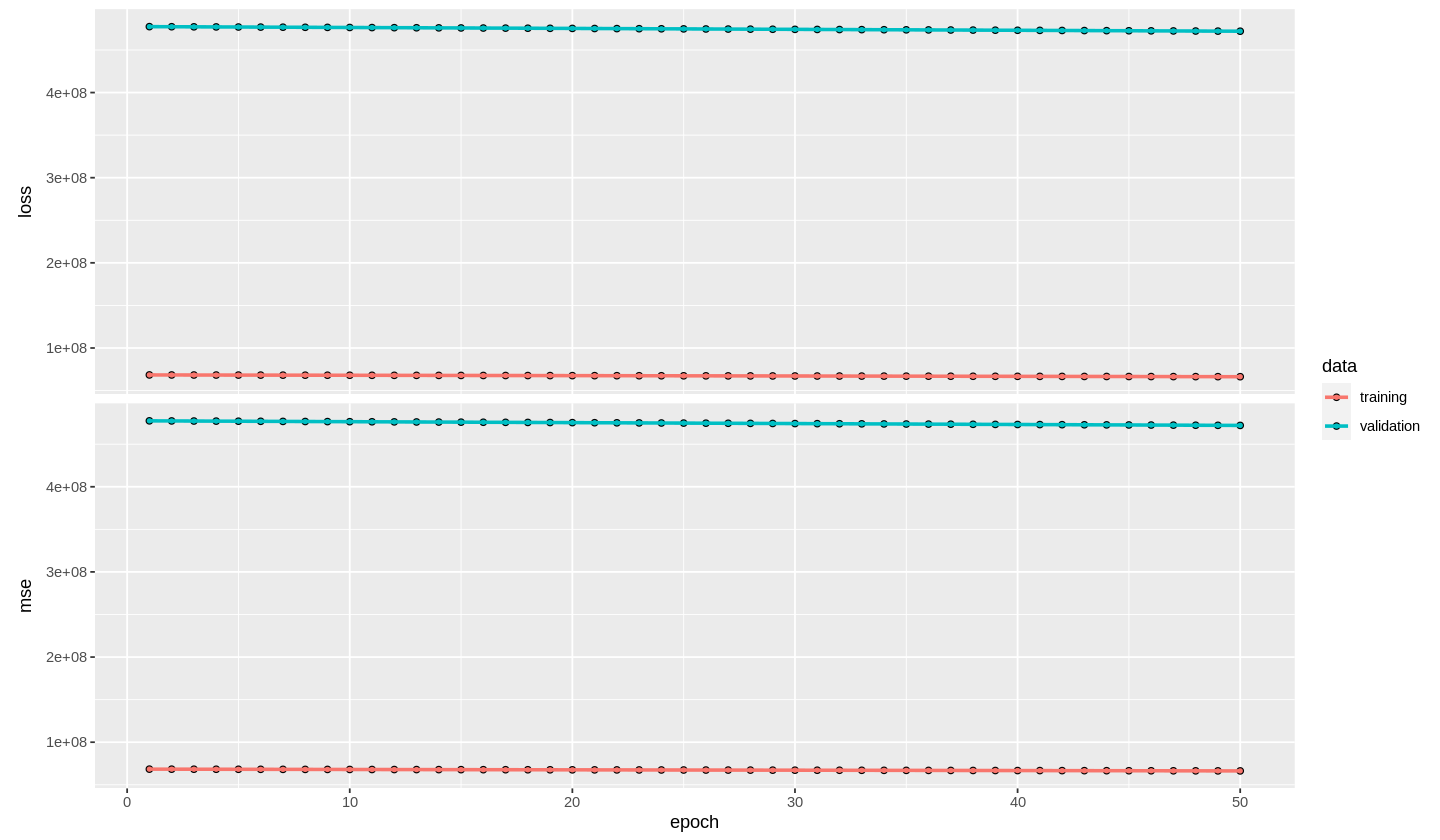

In [127]:
plot(trained_model6)

In [128]:
evaluate(model6, X_train, y_train)

loss       mse 
106993704 106993704

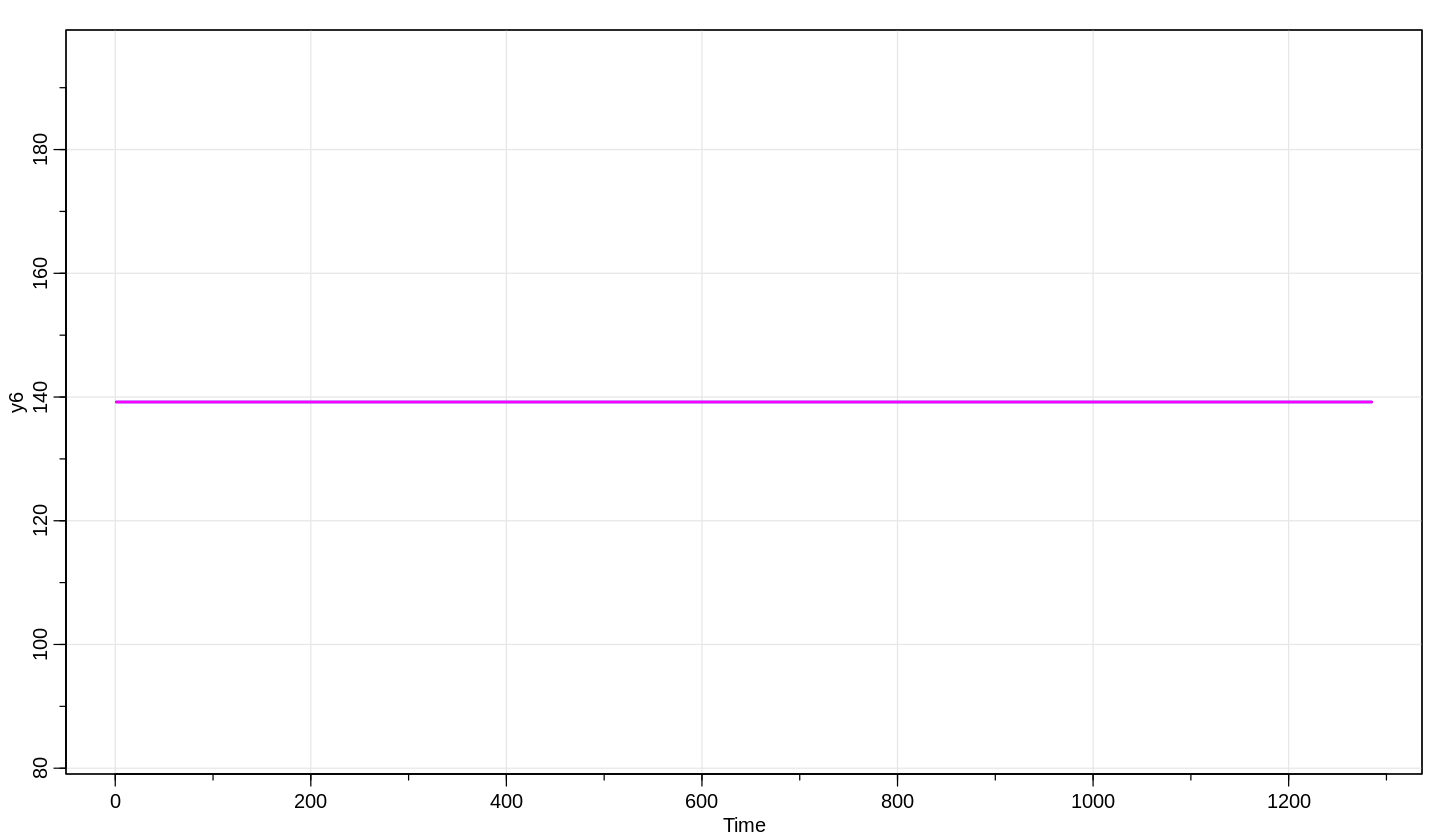

In [129]:
y6 <- predict(model6,X_train)

tsplot(y6, col=4, lwd=2)
lines(y6, col=6, lwd=2)

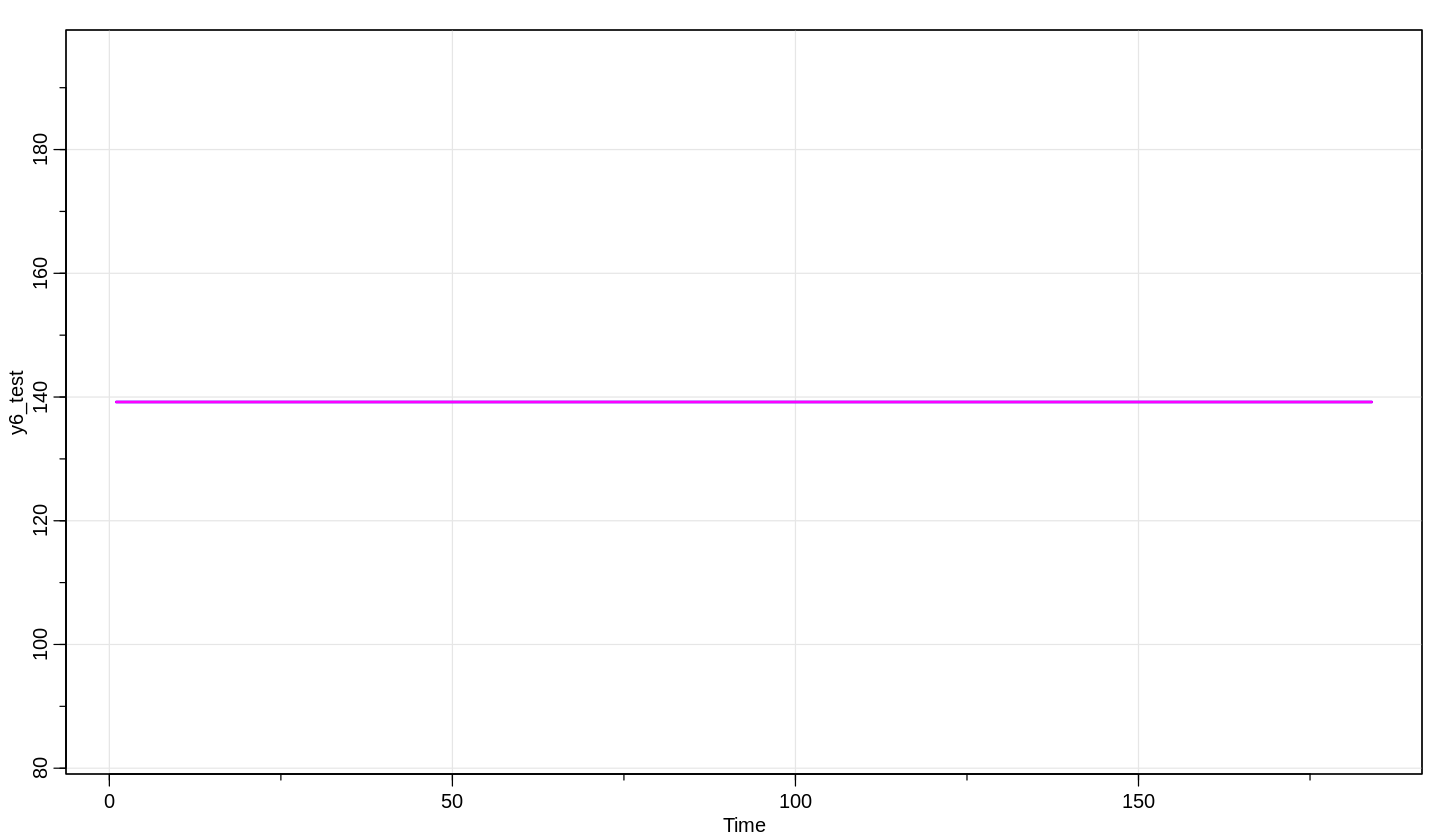

In [130]:
y6_test <- predict(model6,X_test)

tsplot(y6_test, col=4, lwd=2)
lines(y6_test, col=6, lwd=2)

In [131]:
evaluate(model6, X_test, y_test)

loss        mse 
2176381184 2176381184

## Referencias
[1] A GARCH Tutorial with R
https://github.com/msperlin/GARCH-RAC

[2] Modelling the volatility of Bitcoin returns using GARCH models (Samuel Asante Gyamerah)

[3] Modelling and predicting the Bitcoin volatility using GARCH models. https://www.researchgate.net/publication/322261567_Modelling_and_predicting_the_Bitcoin_volatility_using_GARCH_models